In [100]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import keras
import numpy as np
from keras.preprocessing.image import load_img
from keras_vggface.utils import preprocess_input
import tensorflow as tf
import random
from tensorflow.keras.layers import Dense, BatchNormalization,MaxPooling2D
from keras.layers import Dropout, Lambda, Conv2D,GlobalAveragePooling2D
from keras.models import Sequential, Model
from  tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image, ImageOps
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

Function to ensure that all file names contain a 4 digit string at the end

In [2]:
def pad_zeros(num, length):
    temp = str(num)
    while(len(temp) < length):
        temp = "0" + temp
    return temp

Function which radomly generates data for training or testing. It takes in a parameter of number of entries, and an x,y size of the images. This will generate 2n images. It will create an equal amount of matching and non-matching pairs

TODO: Create a method to guarantee that there are no duplicate pairs. Currently the chance of a duplicate pair is very low.

In [26]:
def data_generation(n, x,y):
    data_dir = "D:\\CS274\\images\\original"
    number_of_pairs = n
    pairs = []
    labels = []
    pair_set = set()
    image_locations = data_dir + "\\image_"
    while len(pairs) < number_of_pairs:
        random_base = -1
        random_offset = -1
        random_non_match = -1
     
        while tuple(sorted((random_base, random_non_match))) in pair_set or tuple(sorted((random_base, random_base + random_offset))) in pair_set or random_base < 0:
            random_offset = random.randrange(-2,3)
            while random_offset == 0:
                random_offset = random.randrange(-2,3)
            random_base = random.randrange(3,3161)
            random_non_match = random.randrange(-3000,3162) 
            #pairs are made up of random_Base, random_base + randdom_offset and random_base, random_base + random_non_match3
            while(random_base + random_non_match > 3162 or  random_base + random_non_match < 1):
                random_non_match = random.randrange(1,3162) 

            random_non_match = abs(random_base + random_non_match)
        pair_set.add(tuple(sorted((random_base, random_non_match))))
        pair_set.add(tuple(sorted((random_base, random_base + random_offset))))
        base_image_raw = tf.keras.preprocessing.image.load_img(image_locations + pad_zeros(random_base,4) + ".jpg", color_mode='grayscale',target_size=(x,y))
        base_image = tf.keras.preprocessing.image.img_to_array(base_image_raw)   
        
        match_image_raw = tf.keras.preprocessing.image.load_img(image_locations + pad_zeros(random_base + random_offset,4) + ".jpg", color_mode='grayscale',target_size=(x,y))
        match_image = tf.keras.preprocessing.image.img_to_array(match_image_raw) 
        
        non_match_image_raw = tf.keras.preprocessing.image.load_img(image_locations + pad_zeros(random_non_match,4) + ".jpg", color_mode='grayscale',target_size=(x,y))
        non_match_image = tf.keras.preprocessing.image.img_to_array(non_match_image_raw) 
        pairs.append((base_image, match_image))
        labels.append(1)
        pairs.append((base_image, non_match_image))
        labels.append(0)
    
    return (np.array(pairs), np.array(labels))
 

Implimentation of a Siamese CNN model, adapated from:https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

In [27]:
def build_siamese_model_test2(input_shape=(32, 32, 1)):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    input_shape = Input(shape=input_shape, batch_size=2)
    print(input_shape.shape)

    # Convolutional Neural Network
  #  x =  Sequential()
    #desc-1
    x = Conv2D(32,(3,3), strides=1, activation='relu',padding='same')(input_shape)
   # x = MaxPooling2D(pool_size=(2, 2))(x)
    x = (BatchNormalization())(x)
    #desc-2
    x = (Conv2D(32,(3,3), strides=1, activation='relu',padding='same'))(x)

    x = (BatchNormalization())(x)
    #desc-3
    x = (Conv2D(64,(3,3), strides=2, activation='relu',padding='same'))(x)
    x = (BatchNormalization())(x)
    #desc-4
    x = (Conv2D(64, (3,3),strides=1, activation='relu',padding='same'))(x)
    x = (BatchNormalization())(x)

    #desc-5
    x = (Conv2D(128, (3,3),strides=2, activation='relu',padding='same'))(x)
    x = (BatchNormalization())(x)
    #desc-6
    x = (Conv2D(128, (3,3),strides=1, activation='relu',padding='same'))(x)
    x = (BatchNormalization())(x)
    #desc-7
    x = (Dropout(0.1))(x)
    #desc-8
    x = (Conv2D(128, (8,8),strides=1, activation='relu',padding='same'))(x)
    x = (BatchNormalization())(x)

  
    print(x)
    pooledOutput = GlobalAveragePooling2D()(x)
    #embeddingDim = 48
    outputs = Dense(48)(pooledOutput)
    
    model = Model(input_shape, outputs)
    return model



Function from https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

In [28]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

Initialize the directory of the training data

Function containing model and data intializtion, as well as training

In [197]:
#the following code has been adapted from: 
#https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/
def run_training(x,y,num_of_items,image_dir):
    print("Generating Data")
    (data, labels) = data_generation(num_of_items,x,y)
    
    split = round(len(data) * 0.75)
    pairTrain, labelTrain = (data[0:split], labels[0:split])
    pairTest, labelTest  = (data[split:len(data)-1], labels[split:len(data)-1])
    print("Data Generated")
    featureExtractor = build_siamese_model_test2(input_shape=(x,y,1))

    img1 = Input(shape=(x,y,1), batch_size=1)
    img2 = Input(shape=(x,y,1), batch_size=1)

    featsA = featureExtractor(img1)
    featsB = featureExtractor(img2)
    distance = Lambda(euclidean_distance)([featsA, featsB])
    outputs = Dense(1, activation="sigmoid")(distance)
    model = Model(inputs=[img1, img2], outputs=outputs)
    print("test:")
    print(model.layers)
    model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=["accuracy"])
    
    history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=1, 
    epochs=10,)
    return model

In [77]:
def compare_accuracy(old_model, new_model):
    old_score = old_model.history.history['accuracy'][-1]
    new_score = new_model.history.history['accuracy'][-1]
    if(old_score > new_score):
        return old_model
    else:
        return new_model

In [89]:
image_dir = "D:\\CS274\\images\\original\\"
x = 32
y = 32
num_of_items = 1000
restarts = 100
best_model = None
accuracy = {}
loss = {}
#tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
num_of_items = [100,200,300,400,500,1000]
for item in num_of_items:
    loss[item] = []
    accuracy[item] = []
    for i in range(restarts):
        curr_model = run_training(x,y,item,image_dir)
        accuracy[item].append(curr_model.history.history['accuracy'][-1])
        loss[item].append(curr_model.history.history['loss'][-1])
        #curr_model.save('checkpoints\\model_' + str(i) +"_acc_")
        if best_model == None:
            best_model = curr_model
        else:
            best_model = compare_accuracy(best_model,curr_model)


Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_854), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_854/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_854), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_854/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_855), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_855/kernel:0' shape=(3, 3, 32, 

The following Variables were used a Lambda layer's call (tf.nn.convolution_862), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_862/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_862), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_862/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_863), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_863/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this i

The following Variables were used a Lambda layer's call (tf.nn.bias_add_870), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_870/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_871), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_871/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_871), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_871/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended beh

The following Variables were used a Lambda layer's call (tf.nn.convolution_879), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_879/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_879), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_879/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_880), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_880/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that th

The following Variables were used a Lambda layer's call (tf.nn.bias_add_887), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_887/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_888), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_888/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_888), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_888/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended

KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_895/FusedBatchNormV3:0', description="created by layer 'batch_normalization_895'")
Epoch 1/10
75/75 [==============================] - 3s 19ms/step - loss: 0.6762 - accuracy: 0.4575 - val_loss: 0.6352 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 12ms/step - loss: 0.6404 - accuracy: 0.4695 - val_loss: 0.6313 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 13ms/step - loss: 0.6466 - accuracy: 0.4047 - val_loss: 0.6329 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5199 - accuracy: 0.5409 - val_loss: 0.6290 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 12ms/step - loss: 0.5322 - accuracy: 0.5446 - val_loss: 0.6365 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 12ms/step - loss: 0.4960 - accuracy: 0.5553 - 

75/75 [==============================] - 1s 11ms/step - loss: 0.6712 - accuracy: 0.5194 - val_loss: 0.7347 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6768 - accuracy: 0.4632 - val_loss: 0.7362 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 12ms/step - loss: 0.6468 - accuracy: 0.5537 - val_loss: 0.7366 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6571 - accuracy: 0.5070 - val_loss: 0.7407 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6476 - accuracy: 0.4980 - val_loss: 0.7435 - val_accuracy: 0.5000
Epoch 10/10
75/75 [==============================] - 1s 12ms/step - loss: 0.6388 - accuracy: 0.4803 - val_loss: 0.7461 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_903), but
are not present in its tracked ob

Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_910), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_910/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_910), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_910/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_911), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_911/kernel:0' shape=(3, 3, 32, 

The following Variables were used a Lambda layer's call (tf.nn.convolution_918), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_918/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_918), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_918/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_919), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_919/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this i

The following Variables were used a Lambda layer's call (tf.nn.bias_add_926), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_926/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_927), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_927/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_927), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_927/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended beh

The following Variables were used a Lambda layer's call (tf.nn.convolution_935), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_935/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_935), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_935/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_936), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_936/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that th

The following Variables were used a Lambda layer's call (tf.nn.bias_add_943), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_943/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_944), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_944/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_944), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_944/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended

KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_951/FusedBatchNormV3:0', description="created by layer 'batch_normalization_951'")
Epoch 1/10
75/75 [==============================] - 2s 16ms/step - loss: 0.7224 - accuracy: 0.4136 - val_loss: 0.6402 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6647 - accuracy: 0.4632 - val_loss: 0.6228 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5818 - accuracy: 0.5465 - val_loss: 0.6117 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5656 - accuracy: 0.5134 - val_loss: 0.6026 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5280 - accuracy: 0.5752 - val_loss: 0.5957 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5914 - accuracy: 0.3591 - 

75/75 [==============================] - 1s 11ms/step - loss: 0.6089 - accuracy: 0.4282 - val_loss: 0.6055 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5519 - accuracy: 0.4867 - val_loss: 0.5977 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5141 - accuracy: 0.5565 - val_loss: 0.5871 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5125 - accuracy: 0.5935 - val_loss: 0.5815 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4610 - accuracy: 0.6330 - val_loss: 0.5730 - val_accuracy: 0.5000
Epoch 10/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4965 - accuracy: 0.6655 - val_loss: 0.5702 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_959), but
are not present in its tracked ob

Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_966), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_966/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_966), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_966/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_967), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_967/kernel:0' shape=(3, 3, 32, 

The following Variables were used a Lambda layer's call (tf.nn.convolution_974), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_974/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_974), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_974/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_975), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_975/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this i

The following Variables were used a Lambda layer's call (tf.nn.bias_add_982), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_982/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_983), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_983/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_983), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_983/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended beh

The following Variables were used a Lambda layer's call (tf.nn.convolution_991), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_991/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_991), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_991/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_992), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_992/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that th

The following Variables were used a Lambda layer's call (tf.nn.bias_add_999), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_999/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1000), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1000/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1000), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1000/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1007), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1007/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1007/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1007'")
Epoch 1/10
75/75 [==============================] - 3s 19ms/step - loss: 0.6836 - accuracy: 0.5412 - val_loss: 0.6211 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6777 - accuracy: 0.4667 - val_loss: 0.5981 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6870 - accuracy: 0.3930 - val_loss: 0.5824 - val_accuracy: 0.50

75/75 [==============================] - 1s 10ms/step - loss: 0.6965 - accuracy: 0.5572 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.7013 - accuracy: 0.4431 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6908 - accuracy: 0.4585 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6839 - accuracy: 0.4958 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 9ms/step - loss: 0.6787 - accuracy: 0.4962 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 9ms/step - loss: 0.6697 - accuracy: 0.5152 - val_loss: 0.6986 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 9ms/step - loss: 0.6730 - accuracy: 0.4775 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 9/10
75/75 [=========

Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6272 - accuracy: 0.6155 - val_loss: 0.7499 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6713 - accuracy: 0.4301 - val_loss: 0.7477 - val_accuracy: 0.5000
Epoch 10/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6187 - accuracy: 0.5489 - val_loss: 0.7614 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1022), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1022/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1022), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1029), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1029/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1030), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1030/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1030), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1030/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1037), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1037/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1038), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1038/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1038), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1038/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1045), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1045/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1046), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1046/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1046), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1046/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1053), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1053/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1054), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1054/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1054), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1054/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1061), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1061/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1062), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1062/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1062), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1062/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1069), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1069/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1070), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1070/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1070), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1070/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1077), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1077/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1077/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1077'")
Epoch 1/10
75/75 [==============================] - 3s 15ms/step - loss: 1.1132 - accuracy: 0.4361 - val_loss: 0.8570 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.7904 - accuracy: 0.5107 - val_loss: 0.7880 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.7773 - accuracy: 0.4492 - val_loss: 0.7685 - val_accuracy: 0.50

75/75 [==============================] - 1s 11ms/step - loss: 0.6606 - accuracy: 0.4743 - val_loss: 0.6605 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5960 - accuracy: 0.5424 - val_loss: 0.6522 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6026 - accuracy: 0.4771 - val_loss: 0.6459 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 12ms/step - loss: 0.5506 - accuracy: 0.5246 - val_loss: 0.6409 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5083 - accuracy: 0.5512 - val_loss: 0.6367 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5461 - accuracy: 0.4860 - val_loss: 0.6341 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5024 - accuracy: 0.5196 - val_loss: 0.6353 - val_accuracy: 0.5000
Epoch 9/10
75/75 [======

Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5028 - accuracy: 0.6418 - val_loss: 0.5988 - val_accuracy: 0.5417
Epoch 9/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4750 - accuracy: 0.7635 - val_loss: 0.5970 - val_accuracy: 0.5833
Epoch 10/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4437 - accuracy: 0.7438 - val_loss: 0.6053 - val_accuracy: 0.5833
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1092), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1092/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1092), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1099), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1099/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1100), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1100/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1100), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1100/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1107), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1107/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1108), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1108/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1108), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1108/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1115), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1115/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1116), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1116/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1116), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1116/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1123), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1123/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1124), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1124/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1124), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1124/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1131), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1131/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1132), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1132/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1132), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1132/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1139), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1139/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1140), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1140/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1140), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1140/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1147), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1147/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1147/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1147'")
Epoch 1/10
75/75 [==============================] - 2s 15ms/step - loss: 0.6955 - accuracy: 0.4758 - val_loss: 0.6555 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6209 - accuracy: 0.5503 - val_loss: 0.6410 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5899 - accuracy: 0.5402 - val_loss: 0.6247 - val_accuracy: 0.50

75/75 [==============================] - 1s 11ms/step - loss: 0.7349 - accuracy: 0.5153 - val_loss: 0.7626 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 12ms/step - loss: 0.6864 - accuracy: 0.5645 - val_loss: 0.7526 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 12ms/step - loss: 0.6833 - accuracy: 0.5360 - val_loss: 0.7448 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6668 - accuracy: 0.5408 - val_loss: 0.7425 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6781 - accuracy: 0.4802 - val_loss: 0.7381 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6399 - accuracy: 0.5740 - val_loss: 0.7384 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6726 - accuracy: 0.4157 - val_loss: 0.7365 - val_accuracy: 0.5000
Epoch 9/10
75/75 [======

Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4719 - accuracy: 0.5880 - val_loss: 0.6566 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4406 - accuracy: 0.7905 - val_loss: 0.6596 - val_accuracy: 0.5000
Epoch 10/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4666 - accuracy: 0.8034 - val_loss: 0.6620 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1162), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1162/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1162), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1169), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1169/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1170), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1170/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1170), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1170/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1177), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1177/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1178), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1178/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1178), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1178/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1185), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1185/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1186), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1186/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1186), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1186/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1193), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1193/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1194), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1194/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1194), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1194/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1201), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1201/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1202), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1202/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1202), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1202/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1209), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1209/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1210), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1210/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1210), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1210/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1217), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1217/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1217/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1217'")
Epoch 1/10
75/75 [==============================] - 2s 15ms/step - loss: 0.7559 - accuracy: 0.4603 - val_loss: 0.7160 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.7041 - accuracy: 0.4974 - val_loss: 0.7104 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6869 - accuracy: 0.5761 - val_loss: 0.7086 - val_accuracy: 0.50

75/75 [==============================] - 1s 11ms/step - loss: 0.5833 - accuracy: 0.5677 - val_loss: 0.6513 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6470 - accuracy: 0.4329 - val_loss: 0.6428 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5951 - accuracy: 0.4566 - val_loss: 0.6353 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4945 - accuracy: 0.5975 - val_loss: 0.6300 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5792 - accuracy: 0.4506 - val_loss: 0.6260 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5830 - accuracy: 0.3969 - val_loss: 0.6244 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5139 - accuracy: 0.5753 - val_loss: 0.6257 - val_accuracy: 0.5000
Epoch 9/10
75/75 [======

Epoch 8/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5136 - accuracy: 0.7369 - val_loss: 0.7251 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4224 - accuracy: 0.8279 - val_loss: 0.7429 - val_accuracy: 0.5417
Epoch 10/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4790 - accuracy: 0.7242 - val_loss: 0.7463 - val_accuracy: 0.5417
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1232), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1232/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1232), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1239), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1239/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1240), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1240/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1240), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1240/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1247), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1247/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1248), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1248/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1248), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1248/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1255), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1255/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1256), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1256/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1256), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1256/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1263), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1263/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1264), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1264/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1264), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1264/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1271), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1271/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1272), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1272/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1272), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1272/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1279), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1279/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1280), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1280/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1280), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1280/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1287), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1287/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1287/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1287'")
Epoch 1/10
75/75 [==============================] - 3s 18ms/step - loss: 0.7221 - accuracy: 0.4268 - val_loss: 0.6679 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6321 - accuracy: 0.5069 - val_loss: 0.6559 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6112 - accuracy: 0.5030 - val_loss: 0.6480 - val_accuracy: 0.50

75/75 [==============================] - 1s 11ms/step - loss: 0.6105 - accuracy: 0.6166 - val_loss: 0.6092 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6437 - accuracy: 0.4480 - val_loss: 0.5881 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 11ms/step - loss: 0.5837 - accuracy: 0.4885 - val_loss: 0.5660 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5694 - accuracy: 0.4713 - val_loss: 0.5479 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5277 - accuracy: 0.5497 - val_loss: 0.5320 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4827 - accuracy: 0.6831 - val_loss: 0.5189 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5109 - accuracy: 0.7222 - val_loss: 0.5077 - val_accuracy: 0.5417
Epoch 9/10
75/75 [======

Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5297 - accuracy: 0.5775 - val_loss: 0.5555 - val_accuracy: 0.5417
Epoch 9/10
75/75 [==============================] - 1s 11ms/step - loss: 0.4854 - accuracy: 0.7598 - val_loss: 0.5513 - val_accuracy: 0.5417
Epoch 10/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4615 - accuracy: 0.7251 - val_loss: 0.5523 - val_accuracy: 0.5417
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1302), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1302/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1302), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1309), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1309/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1310), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1310/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1310), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1310/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1317), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1317/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1318), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1318/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1318), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1318/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1325), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1325/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1326), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1326/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1326), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1326/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1333), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1333/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1334), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1334/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1334), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1334/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1341), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1341/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1342), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1342/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1342), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1342/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1349), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1349/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1350), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1350/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1350), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1350/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1357), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1357/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1357/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1357'")
Epoch 1/10
75/75 [==============================] - 2s 15ms/step - loss: 0.6869 - accuracy: 0.4294 - val_loss: 0.6723 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6830 - accuracy: 0.4226 - val_loss: 0.6599 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 11ms/step - loss: 0.6220 - accuracy: 0.5259 - val_loss: 0.6378 - val_accuracy: 0.50

75/75 [==============================] - 1s 10ms/step - loss: 0.6795 - accuracy: 0.4832 - val_loss: 0.6744 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6315 - accuracy: 0.4919 - val_loss: 0.6490 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5960 - accuracy: 0.4709 - val_loss: 0.6463 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 9ms/step - loss: 0.5640 - accuracy: 0.5283 - val_loss: 0.6463 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5211 - accuracy: 0.5964 - val_loss: 0.6467 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5062 - accuracy: 0.7205 - val_loss: 0.6456 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5854 - accuracy: 0.6990 - val_loss: 0.6509 - val_accuracy: 0.5000
Epoch 9/10
75/75 [=======

Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6127 - accuracy: 0.6299 - val_loss: 0.7608 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6663 - accuracy: 0.4541 - val_loss: 0.7581 - val_accuracy: 0.5000
Epoch 10/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6482 - accuracy: 0.4735 - val_loss: 0.7641 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1372), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1372/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1372), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1379), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1379/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1380), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1380/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1380), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1380/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1387), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1387/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1388), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1388/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1388), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1388/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1395), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1395/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1396), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1396/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1396), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1396/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1403), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1403/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1404), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1404/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1404), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1404/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1411), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1411/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1412), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1412/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1412), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1412/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1419), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1419/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1420), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1420/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1420), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1420/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1427), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1427/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1427/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1427'")
Epoch 1/10
75/75 [==============================] - 2s 15ms/step - loss: 0.7120 - accuracy: 0.4368 - val_loss: 0.6759 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6365 - accuracy: 0.5341 - val_loss: 0.6670 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6114 - accuracy: 0.5300 - val_loss: 0.6582 - val_accuracy: 0.50

75/75 [==============================] - 1s 11ms/step - loss: 0.6473 - accuracy: 0.4892 - val_loss: 0.6443 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6327 - accuracy: 0.4126 - val_loss: 0.6265 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5450 - accuracy: 0.5195 - val_loss: 0.6161 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5191 - accuracy: 0.4987 - val_loss: 0.6079 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4970 - accuracy: 0.5145 - val_loss: 0.6020 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4987 - accuracy: 0.5123 - val_loss: 0.5949 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5028 - accuracy: 0.6445 - val_loss: 0.5919 - val_accuracy: 0.5000
Epoch 9/10
75/75 [======

Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.5094 - accuracy: 0.5846 - val_loss: 0.6582 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4722 - accuracy: 0.6717 - val_loss: 0.6298 - val_accuracy: 0.5417
Epoch 10/10
75/75 [==============================] - 1s 10ms/step - loss: 0.4325 - accuracy: 0.8691 - val_loss: 0.6326 - val_accuracy: 0.5417
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1442), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1442/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1442), but
are not present in its tracked objects:
  <tf.Varia

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1449), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1449/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1450), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1450/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1450), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1450/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1457), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1457/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1458), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1458/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1458), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1458/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1465), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1465/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1466), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1466/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1466), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1466/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1473), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1473/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1474), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1474/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1474), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1474/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1481), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1481/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1482), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1482/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1482), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1482/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1489), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1489/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1490), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1490/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1490), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1490/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1497), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1497/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1497/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1497'")
Epoch 1/10
75/75 [==============================] - 3s 19ms/step - loss: 0.7953 - accuracy: 0.4709 - val_loss: 0.7313 - val_accuracy: 0.5000
Epoch 2/10
75/75 [==============================] - 1s 12ms/step - loss: 0.7227 - accuracy: 0.4717 - val_loss: 0.7154 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6923 - accuracy: 0.4975 - val_loss: 0.7136 - val_accuracy: 0.50

75/75 [==============================] - 1s 10ms/step - loss: 0.7325 - accuracy: 0.4842 - val_loss: 0.7318 - val_accuracy: 0.5000
Epoch 3/10
75/75 [==============================] - 1s 10ms/step - loss: 0.7037 - accuracy: 0.4856 - val_loss: 0.7255 - val_accuracy: 0.5000
Epoch 4/10
75/75 [==============================] - 1s 9ms/step - loss: 0.6767 - accuracy: 0.5402 - val_loss: 0.7244 - val_accuracy: 0.5000
Epoch 5/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6861 - accuracy: 0.4764 - val_loss: 0.7224 - val_accuracy: 0.5000
Epoch 6/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6567 - accuracy: 0.5396 - val_loss: 0.7246 - val_accuracy: 0.5000
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6560 - accuracy: 0.5500 - val_loss: 0.7240 - val_accuracy: 0.5000
Epoch 8/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6444 - accuracy: 0.5184 - val_loss: 0.7270 - val_accuracy: 0.5000
Epoch 9/10
75/75 [=======

Epoch 8/10
75/75 [==============================] - 1s 9ms/step - loss: 0.6587 - accuracy: 0.4344 - val_loss: 0.7200 - val_accuracy: 0.5000
Epoch 9/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6352 - accuracy: 0.5440 - val_loss: 0.7232 - val_accuracy: 0.5000
Epoch 10/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6403 - accuracy: 0.4500 - val_loss: 0.7313 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1512), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1512/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1512), but
are not present in its tracked objects:
  <tf.Variab

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1519), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1519/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1520), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1520/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1520), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1520/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1527), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1527/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1528), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1528/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1528), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1528/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1535), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1535/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1536), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1536/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1536), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1536/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1543), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1543/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1544), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1544/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1544), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1544/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1551), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1551/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1552), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1552/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1552), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1552/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1559), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1559/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1560), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1560/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1560), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1560/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1567), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1567/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1567/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1567'")
Epoch 1/10
150/150 [==============================] - 3s 13ms/step - loss: 0.7252 - accuracy: 0.5027 - val_loss: 0.6818 - val_accuracy: 0.4898
Epoch 2/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5949 - accuracy: 0.5393 - val_loss: 0.6514 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6005 - accuracy: 0.4865 - val_loss: 0.6364 - val_accuracy

150/150 [==============================] - 1s 9ms/step - loss: 0.7301 - accuracy: 0.4724 - val_loss: 0.7283 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 1s 9ms/step - loss: 0.7078 - accuracy: 0.4691 - val_loss: 0.7191 - val_accuracy: 0.5102
Epoch 4/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6852 - accuracy: 0.5063 - val_loss: 0.7174 - val_accuracy: 0.5102
Epoch 5/10
150/150 [==============================] - 1s 9ms/step - loss: 0.6757 - accuracy: 0.5048 - val_loss: 0.7123 - val_accuracy: 0.5102
Epoch 6/10
150/150 [==============================] - 1s 9ms/step - loss: 0.6722 - accuracy: 0.4664 - val_loss: 0.7097 - val_accuracy: 0.5102
Epoch 7/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6622 - accuracy: 0.4927 - val_loss: 0.7112 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6390 - accuracy: 0.5485 - val_loss: 0.7146 - val_accuracy: 0.5102
Epoch 9/10
150

150/150 [==============================] - 2s 11ms/step - loss: 0.4431 - accuracy: 0.7554 - val_loss: 0.6064 - val_accuracy: 0.6327
Epoch 8/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3832 - accuracy: 0.8764 - val_loss: 0.6063 - val_accuracy: 0.6327
Epoch 9/10
150/150 [==============================] - 2s 12ms/step - loss: 0.4307 - accuracy: 0.8804 - val_loss: 0.6127 - val_accuracy: 0.6531
Epoch 10/10
150/150 [==============================] - 2s 12ms/step - loss: 0.3796 - accuracy: 0.8966 - val_loss: 0.6104 - val_accuracy: 0.6531
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1582), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1582/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1589), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1589/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1590), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1590/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1590), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1590/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1597), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1597/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1598), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1598/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1598), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1598/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1605), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1605/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1606), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1606/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1606), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1606/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1613), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1613/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1614), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1614/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1614), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1614/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1621), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1621/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1622), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1622/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1622), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1622/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1629), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1629/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1630), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1630/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1630), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1630/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1637), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1637/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1637/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1637'")
Epoch 1/10
150/150 [==============================] - 3s 12ms/step - loss: 0.8543 - accuracy: 0.4794 - val_loss: 0.7486 - val_accuracy: 0.5306
Epoch 2/10
150/150 [==============================] - 2s 10ms/step - loss: 0.7095 - accuracy: 0.5236 - val_loss: 0.7268 - val_accuracy: 0.5306
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6906 - accuracy: 0.4952 - val_loss: 0.7194 - val_accuracy

150/150 [==============================] - 2s 11ms/step - loss: 0.6321 - accuracy: 0.4976 - val_loss: 0.6610 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 2s 11ms/step - loss: 0.5475 - accuracy: 0.5796 - val_loss: 0.6469 - val_accuracy: 0.4898
Epoch 4/10
150/150 [==============================] - 2s 11ms/step - loss: 0.5886 - accuracy: 0.4697 - val_loss: 0.6394 - val_accuracy: 0.4898
Epoch 5/10
150/150 [==============================] - 2s 11ms/step - loss: 0.5210 - accuracy: 0.5714 - val_loss: 0.6329 - val_accuracy: 0.4898
Epoch 6/10
150/150 [==============================] - 2s 11ms/step - loss: 0.5140 - accuracy: 0.5836 - val_loss: 0.6264 - val_accuracy: 0.4898
Epoch 7/10
150/150 [==============================] - 2s 12ms/step - loss: 0.5030 - accuracy: 0.6641 - val_loss: 0.6241 - val_accuracy: 0.4898
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4481 - accuracy: 0.7899 - val_loss: 0.6216 - val_accuracy: 0.5102
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.4705 - accuracy: 0.7946 - val_loss: 0.5716 - val_accuracy: 0.5918
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4219 - accuracy: 0.8013 - val_loss: 0.5606 - val_accuracy: 0.6531
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4201 - accuracy: 0.9047 - val_loss: 0.5552 - val_accuracy: 0.6531
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4145 - accuracy: 0.8789 - val_loss: 0.5552 - val_accuracy: 0.6735
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1652), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1652/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1659), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1659/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1660), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1660/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1660), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1660/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1667), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1667/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1668), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1668/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1668), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1668/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1675), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1675/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1676), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1676/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1676), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1676/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1683), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1683/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1684), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1684/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1684), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1684/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1691), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1691/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1692), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1692/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1692), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1692/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1699), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1699/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1700), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1700/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1700), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1700/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1707), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1707/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1707/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1707'")
Epoch 1/10
150/150 [==============================] - 3s 13ms/step - loss: 0.7005 - accuracy: 0.5036 - val_loss: 0.6660 - val_accuracy: 0.4898
Epoch 2/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5956 - accuracy: 0.5908 - val_loss: 0.6420 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5720 - accuracy: 0.5369 - val_loss: 0.6192 - val_accuracy

150/150 [==============================] - 2s 11ms/step - loss: 0.5804 - accuracy: 0.5137 - val_loss: 0.6409 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5813 - accuracy: 0.4806 - val_loss: 0.6370 - val_accuracy: 0.4898
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5543 - accuracy: 0.5535 - val_loss: 0.6270 - val_accuracy: 0.5102
Epoch 5/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5633 - accuracy: 0.5715 - val_loss: 0.6190 - val_accuracy: 0.5306
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.4719 - accuracy: 0.7306 - val_loss: 0.6208 - val_accuracy: 0.5306
Epoch 7/10
150/150 [==============================] - 2s 11ms/step - loss: 0.5252 - accuracy: 0.7506 - val_loss: 0.6215 - val_accuracy: 0.5306
Epoch 8/10
150/150 [==============================] - 2s 12ms/step - loss: 0.4796 - accuracy: 0.7685 - val_loss: 0.6001 - val_accuracy: 0.6735
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.6852 - accuracy: 0.4881 - val_loss: 0.6935 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6822 - accuracy: 0.4750 - val_loss: 0.6934 - val_accuracy: 0.5102
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6735 - accuracy: 0.5051 - val_loss: 0.6955 - val_accuracy: 0.5102
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6605 - accuracy: 0.5151 - val_loss: 0.6958 - val_accuracy: 0.5102
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1722), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1722/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1729), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1729/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1730), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1730/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1730), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1730/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1737), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1737/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1738), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1738/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1738), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1738/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1745), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1745/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1746), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1746/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1746), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1746/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1753), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1753/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1754), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1754/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1754), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1754/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1761), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1761/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1762), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1762/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1762), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1762/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1769), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1769/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1770), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1770/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1770), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1770/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1777), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1777/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1777/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1777'")
Epoch 1/10
150/150 [==============================] - 3s 12ms/step - loss: 0.6763 - accuracy: 0.4634 - val_loss: 0.6694 - val_accuracy: 0.4898
Epoch 2/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6028 - accuracy: 0.5847 - val_loss: 0.6587 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5684 - accuracy: 0.5865 - val_loss: 0.6493 - val_accuracy

150/150 [==============================] - 2s 10ms/step - loss: 0.7317 - accuracy: 0.5345 - val_loss: 0.7500 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.7166 - accuracy: 0.4967 - val_loss: 0.7382 - val_accuracy: 0.5102
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6990 - accuracy: 0.4945 - val_loss: 0.7237 - val_accuracy: 0.5102
Epoch 5/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6748 - accuracy: 0.5571 - val_loss: 0.7218 - val_accuracy: 0.5102
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6611 - accuracy: 0.5244 - val_loss: 0.7175 - val_accuracy: 0.5102
Epoch 7/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6503 - accuracy: 0.5682 - val_loss: 0.7217 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6555 - accuracy: 0.4904 - val_loss: 0.7240 - val_accuracy: 0.5102
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.6898 - accuracy: 0.4287 - val_loss: 0.7002 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6839 - accuracy: 0.4958 - val_loss: 0.7018 - val_accuracy: 0.5102
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6786 - accuracy: 0.5169 - val_loss: 0.7060 - val_accuracy: 0.5102
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6759 - accuracy: 0.5105 - val_loss: 0.7093 - val_accuracy: 0.5102
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1792), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1792/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1799), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1799/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1800), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1800/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1800), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1800/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1807), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1807/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1808), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1808/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1808), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1808/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1815), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1815/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1816), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1816/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1816), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1816/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1823), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1823/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1824), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1824/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1824), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1824/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1831), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1831/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1832), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1832/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1832), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1832/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1839), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1839/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1840), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1840/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1840), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1840/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1847), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1847/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1847/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1847'")
Epoch 1/10
150/150 [==============================] - 3s 13ms/step - loss: 0.7394 - accuracy: 0.4462 - val_loss: 0.7035 - val_accuracy: 0.5102
Epoch 2/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6870 - accuracy: 0.5917 - val_loss: 0.6990 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6946 - accuracy: 0.5020 - val_loss: 0.6973 - val_accuracy

150/150 [==============================] - 2s 10ms/step - loss: 0.6535 - accuracy: 0.4821 - val_loss: 0.6378 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6335 - accuracy: 0.4759 - val_loss: 0.6212 - val_accuracy: 0.4898
Epoch 4/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5663 - accuracy: 0.5441 - val_loss: 0.6118 - val_accuracy: 0.4898
Epoch 5/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5680 - accuracy: 0.5022 - val_loss: 0.6045 - val_accuracy: 0.4898
Epoch 6/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5417 - accuracy: 0.6243 - val_loss: 0.5982 - val_accuracy: 0.5102
Epoch 7/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5285 - accuracy: 0.6908 - val_loss: 0.5940 - val_accuracy: 0.5306
Epoch 8/10
150/150 [==============================] - 2s 10ms/step - loss: 0.4698 - accuracy: 0.6963 - val_loss: 0.5894 - val_accuracy: 0.5510
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.5151 - accuracy: 0.7473 - val_loss: 0.6169 - val_accuracy: 0.5714
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4837 - accuracy: 0.8008 - val_loss: 0.6088 - val_accuracy: 0.6122
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4150 - accuracy: 0.8414 - val_loss: 0.6116 - val_accuracy: 0.6327
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4569 - accuracy: 0.8531 - val_loss: 0.6002 - val_accuracy: 0.6735
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1862), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1862/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1869), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1869/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1870), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1870/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1870), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1870/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1877), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1877/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1878), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1878/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1878), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1878/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1885), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1885/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1886), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1886/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1886), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1886/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1893), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1893/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1894), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1894/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1894), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1894/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1901), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1901/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1902), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1902/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1902), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1902/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1909), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1909/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1910), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1910/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1910), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1910/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1917), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1917/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1917/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1917'")
Epoch 1/10
150/150 [==============================] - 3s 14ms/step - loss: 0.7552 - accuracy: 0.5278 - val_loss: 0.7228 - val_accuracy: 0.5102
Epoch 2/10
150/150 [==============================] - 2s 11ms/step - loss: 0.7271 - accuracy: 0.4273 - val_loss: 0.7154 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6986 - accuracy: 0.4826 - val_loss: 0.7103 - val_accuracy

150/150 [==============================] - 2s 10ms/step - loss: 0.6961 - accuracy: 0.5472 - val_loss: 0.7306 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6882 - accuracy: 0.5352 - val_loss: 0.7187 - val_accuracy: 0.5102
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6752 - accuracy: 0.5150 - val_loss: 0.7162 - val_accuracy: 0.5102
Epoch 5/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6564 - accuracy: 0.5522 - val_loss: 0.7156 - val_accuracy: 0.5102
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6734 - accuracy: 0.4879 - val_loss: 0.7169 - val_accuracy: 0.5102
Epoch 7/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6577 - accuracy: 0.4947 - val_loss: 0.7183 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6581 - accuracy: 0.4663 - val_loss: 0.7202 - val_accuracy: 0.5102
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.6703 - accuracy: 0.4808 - val_loss: 0.7207 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6696 - accuracy: 0.4550 - val_loss: 0.7173 - val_accuracy: 0.5102
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6560 - accuracy: 0.4739 - val_loss: 0.7269 - val_accuracy: 0.5102
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6482 - accuracy: 0.4763 - val_loss: 0.7413 - val_accuracy: 0.5102
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_1932), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1932/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1939), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1939/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1940), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1940/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1940), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1940/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1947), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1947/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1948), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1948/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1948), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1948/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1955), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1955/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1956), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1956/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1956), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1956/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1963), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1963/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1964), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1964/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1964), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1964/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1971), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1971/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1972), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1972/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1972), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1972/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1979), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1979/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_1980), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1980/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_1980), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1980/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_1987), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_1987/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_1987/FusedBatchNormV3:0', description="created by layer 'batch_normalization_1987'")
Epoch 1/10
150/150 [==============================] - 3s 14ms/step - loss: 0.8028 - accuracy: 0.4395 - val_loss: 0.7219 - val_accuracy: 0.5102
Epoch 2/10
150/150 [==============================] - 2s 10ms/step - loss: 0.7129 - accuracy: 0.5090 - val_loss: 0.7087 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6934 - accuracy: 0.5164 - val_loss: 0.7048 - val_accuracy

150/150 [==============================] - 2s 10ms/step - loss: 0.6245 - accuracy: 0.4967 - val_loss: 0.6393 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5485 - accuracy: 0.5451 - val_loss: 0.6170 - val_accuracy: 0.4898
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5572 - accuracy: 0.5176 - val_loss: 0.6019 - val_accuracy: 0.4898
Epoch 5/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5599 - accuracy: 0.5140 - val_loss: 0.5920 - val_accuracy: 0.4898
Epoch 6/10
150/150 [==============================] - 1s 10ms/step - loss: 0.5284 - accuracy: 0.6827 - val_loss: 0.5847 - val_accuracy: 0.5306
Epoch 7/10
150/150 [==============================] - 2s 10ms/step - loss: 0.4873 - accuracy: 0.7135 - val_loss: 0.5674 - val_accuracy: 0.5918
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4205 - accuracy: 0.8510 - val_loss: 0.5568 - val_accuracy: 0.6735
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.6599 - accuracy: 0.5294 - val_loss: 0.7189 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6757 - accuracy: 0.4025 - val_loss: 0.7193 - val_accuracy: 0.5102
Epoch 9/10
150/150 [==============================] - 2s 12ms/step - loss: 0.6466 - accuracy: 0.5239 - val_loss: 0.7253 - val_accuracy: 0.5102
Epoch 10/10
150/150 [==============================] - 2s 12ms/step - loss: 0.6450 - accuracy: 0.5158 - val_loss: 0.7316 - val_accuracy: 0.5102
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2002), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2002/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2009), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2009/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2010), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2010/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2010), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2010/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2017), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2017/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2018), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2018/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2018), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2018/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2025), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2025/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2026), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2026/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2026), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2026/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2033), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2033/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2034), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2034/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2034), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2034/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2041), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2041/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2042), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2042/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2042), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2042/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2049), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2049/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2050), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2050/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2050), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2050/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2057), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2057/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2057/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2057'")
Epoch 1/10
150/150 [==============================] - 3s 12ms/step - loss: 0.9439 - accuracy: 0.4534 - val_loss: 0.7617 - val_accuracy: 0.5102
Epoch 2/10
150/150 [==============================] - 1s 10ms/step - loss: 0.7496 - accuracy: 0.4885 - val_loss: 0.7338 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6892 - accuracy: 0.5530 - val_loss: 0.7222 - val_accuracy

150/150 [==============================] - 1s 10ms/step - loss: 0.6913 - accuracy: 0.5422 - val_loss: 0.6995 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6903 - accuracy: 0.5150 - val_loss: 0.6992 - val_accuracy: 0.5102
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6871 - accuracy: 0.4941 - val_loss: 0.6991 - val_accuracy: 0.5102
Epoch 5/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6845 - accuracy: 0.4701 - val_loss: 0.7002 - val_accuracy: 0.5102
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6755 - accuracy: 0.5007 - val_loss: 0.7007 - val_accuracy: 0.5102
Epoch 7/10
150/150 [==============================] - 1s 10ms/step - loss: 0.6712 - accuracy: 0.5095 - val_loss: 0.7029 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6703 - accuracy: 0.4350 - val_loss: 0.7092 - val_accuracy: 0.5102
Epoch 9/10

150/150 [==============================] - 2s 10ms/step - loss: 0.4600 - accuracy: 0.7647 - val_loss: 0.5562 - val_accuracy: 0.6122
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4353 - accuracy: 0.8591 - val_loss: 0.5442 - val_accuracy: 0.6939
Epoch 9/10
150/150 [==============================] - 2s 10ms/step - loss: 0.4218 - accuracy: 0.9019 - val_loss: 0.5442 - val_accuracy: 0.7143
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4309 - accuracy: 0.8687 - val_loss: 0.5275 - val_accuracy: 0.7347
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2072), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2072/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2079), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2079/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2080), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2080/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2080), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2080/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2087), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2087/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2088), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2088/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2088), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2088/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2095), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2095/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2096), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2096/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2096), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2096/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2103), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2103/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2104), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2104/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2104), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2104/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2111), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2111/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2112), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2112/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2112), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2112/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2119), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2119/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2120), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2120/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2120), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2120/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2127), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2127/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2127/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2127'")
Epoch 1/10
150/150 [==============================] - 3s 13ms/step - loss: 0.7326 - accuracy: 0.4762 - val_loss: 0.6982 - val_accuracy: 0.5102
Epoch 2/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6891 - accuracy: 0.5810 - val_loss: 0.6964 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6959 - accuracy: 0.4677 - val_loss: 0.6958 - val_accuracy

150/150 [==============================] - 2s 10ms/step - loss: 0.6150 - accuracy: 0.4833 - val_loss: 0.6028 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6098 - accuracy: 0.4470 - val_loss: 0.5926 - val_accuracy: 0.5102
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5587 - accuracy: 0.4936 - val_loss: 0.5831 - val_accuracy: 0.5306
Epoch 5/10
150/150 [==============================] - 2s 11ms/step - loss: 0.5370 - accuracy: 0.5896 - val_loss: 0.5740 - val_accuracy: 0.5714
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5034 - accuracy: 0.6861 - val_loss: 0.5660 - val_accuracy: 0.6531
Epoch 7/10
150/150 [==============================] - 2s 10ms/step - loss: 0.4994 - accuracy: 0.7150 - val_loss: 0.5581 - val_accuracy: 0.7143
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.4282 - accuracy: 0.7695 - val_loss: 0.5511 - val_accuracy: 0.7959
Epoch 9/10

150/150 [==============================] - 2s 11ms/step - loss: 0.6420 - accuracy: 0.5714 - val_loss: 0.7207 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6431 - accuracy: 0.5246 - val_loss: 0.7249 - val_accuracy: 0.5102
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6529 - accuracy: 0.4318 - val_loss: 0.7312 - val_accuracy: 0.5102
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6263 - accuracy: 0.5123 - val_loss: 0.7375 - val_accuracy: 0.5102
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2142), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2142/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2149), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2149/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2150), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2150/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2150), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2150/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2157), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2157/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2158), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2158/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2158), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2158/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2165), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2165/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2166), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2166/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2166), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2166/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2173), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2173/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2174), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2174/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2174), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2174/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2181), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2181/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2182), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2182/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2182), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2182/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2189), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2189/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2190), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2190/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2190), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2190/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2197), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2197/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2197/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2197'")
Epoch 1/10
150/150 [==============================] - 3s 14ms/step - loss: 0.6843 - accuracy: 0.4860 - val_loss: 0.6489 - val_accuracy: 0.4898
Epoch 2/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6286 - accuracy: 0.4893 - val_loss: 0.6255 - val_accuracy: 0.4898
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.5509 - accuracy: 0.5150 - val_loss: 0.6036 - val_accuracy

150/150 [==============================] - 1s 10ms/step - loss: 0.7024 - accuracy: 0.4758 - val_loss: 0.6986 - val_accuracy: 0.5102
Epoch 3/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6906 - accuracy: 0.5215 - val_loss: 0.6980 - val_accuracy: 0.5102
Epoch 4/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6866 - accuracy: 0.5096 - val_loss: 0.6982 - val_accuracy: 0.5102
Epoch 5/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6838 - accuracy: 0.5128 - val_loss: 0.7000 - val_accuracy: 0.5102
Epoch 6/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6741 - accuracy: 0.5599 - val_loss: 0.7011 - val_accuracy: 0.5102
Epoch 7/10
150/150 [==============================] - 2s 10ms/step - loss: 0.6692 - accuracy: 0.5536 - val_loss: 0.7050 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6744 - accuracy: 0.4290 - val_loss: 0.7099 - val_accuracy: 0.5102
Epoch 9/10

150/150 [==============================] - 2s 10ms/step - loss: 0.6655 - accuracy: 0.5003 - val_loss: 0.7073 - val_accuracy: 0.5102
Epoch 8/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6575 - accuracy: 0.4882 - val_loss: 0.7110 - val_accuracy: 0.5102
Epoch 9/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6504 - accuracy: 0.5186 - val_loss: 0.7124 - val_accuracy: 0.5102
Epoch 10/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6519 - accuracy: 0.4853 - val_loss: 0.7147 - val_accuracy: 0.5102
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2212), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2212/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2219), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2219/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2220), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2220/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2220), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2220/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2227), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2227/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2228), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2228/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2228), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2228/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2235), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2235/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2236), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2236/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2236), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2236/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2243), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2243/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2244), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2244/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2244), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2244/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2251), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2251/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2252), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2252/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2252), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2252/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2259), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2259/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2260), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2260/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2260), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2260/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2267), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2267/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2267/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2267'")
Epoch 1/10
225/225 [==============================] - 4s 12ms/step - loss: 0.7007 - accuracy: 0.4941 - val_loss: 0.6318 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6121 - accuracy: 0.4627 - val_loss: 0.5866 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.5530 - accuracy: 0.4913 - val_loss: 0.5626 - val_accuracy

225/225 [==============================] - 2s 11ms/step - loss: 0.5940 - accuracy: 0.4758 - val_loss: 0.5656 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5408 - accuracy: 0.5173 - val_loss: 0.5447 - val_accuracy: 0.5811
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5189 - accuracy: 0.6191 - val_loss: 0.5274 - val_accuracy: 0.6622
Epoch 5/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4879 - accuracy: 0.7444 - val_loss: 0.5124 - val_accuracy: 0.7432
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.4693 - accuracy: 0.8211 - val_loss: 0.4994 - val_accuracy: 0.7568
Epoch 7/10
225/225 [==============================] - 2s 11ms/step - loss: 0.4598 - accuracy: 0.8062 - val_loss: 0.4903 - val_accuracy: 0.7973
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.4380 - accuracy: 0.8466 - val_loss: 0.4776 - val_accuracy: 0.8378
Epoch 9/10

225/225 [==============================] - 3s 12ms/step - loss: 0.4647 - accuracy: 0.7935 - val_loss: 0.5751 - val_accuracy: 0.5946
Epoch 8/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4331 - accuracy: 0.8685 - val_loss: 0.5715 - val_accuracy: 0.6351
Epoch 9/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4191 - accuracy: 0.9071 - val_loss: 0.5697 - val_accuracy: 0.6757
Epoch 10/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4033 - accuracy: 0.9074 - val_loss: 0.5737 - val_accuracy: 0.6892
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2282), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2282/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2289), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2289/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2290), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2290/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2290), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2290/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2297), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2297/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2298), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2298/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2298), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2298/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2305), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2305/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2306), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2306/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2306), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2306/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2313), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2313/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2314), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2314/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2314), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2314/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2321), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2321/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2322), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2322/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2322), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2322/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2329), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2329/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2330), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2330/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2330), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2330/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2337), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2337/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2337/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2337'")
Epoch 1/10
225/225 [==============================] - 4s 11ms/step - loss: 0.9732 - accuracy: 0.4614 - val_loss: 0.7470 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 10ms/step - loss: 0.7533 - accuracy: 0.4641 - val_loss: 0.7180 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6876 - accuracy: 0.5624 - val_loss: 0.7126 - val_accuracy

225/225 [==============================] - 2s 11ms/step - loss: 0.5692 - accuracy: 0.5168 - val_loss: 0.6054 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5465 - accuracy: 0.5341 - val_loss: 0.5935 - val_accuracy: 0.5541
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5353 - accuracy: 0.5906 - val_loss: 0.5811 - val_accuracy: 0.5946
Epoch 5/10
225/225 [==============================] - 3s 11ms/step - loss: 0.5380 - accuracy: 0.7143 - val_loss: 0.5674 - val_accuracy: 0.6216
Epoch 6/10
225/225 [==============================] - 3s 11ms/step - loss: 0.4783 - accuracy: 0.8402 - val_loss: 0.5605 - val_accuracy: 0.6486
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4500 - accuracy: 0.8587 - val_loss: 0.5515 - val_accuracy: 0.6892
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.4280 - accuracy: 0.8493 - val_loss: 0.5451 - val_accuracy: 0.7027
Epoch 9/10

225/225 [==============================] - 3s 11ms/step - loss: 0.6666 - accuracy: 0.4917 - val_loss: 0.7170 - val_accuracy: 0.5000
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6643 - accuracy: 0.4605 - val_loss: 0.7215 - val_accuracy: 0.5000
Epoch 9/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6427 - accuracy: 0.5369 - val_loss: 0.7279 - val_accuracy: 0.4865
Epoch 10/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6476 - accuracy: 0.5320 - val_loss: 0.7344 - val_accuracy: 0.4865
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2352), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2352/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2359), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2359/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2360), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2360/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2360), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2360/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2367), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2367/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2368), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2368/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2368), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2368/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2375), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2375/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2376), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2376/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2376), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2376/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2383), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2383/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2384), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2384/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2384), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2384/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2391), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2391/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2392), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2392/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2392), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2392/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2399), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2399/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2400), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2400/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2400), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2400/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2407), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2407/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2407/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2407'")
Epoch 1/10
225/225 [==============================] - 4s 12ms/step - loss: 0.6385 - accuracy: 0.5246 - val_loss: 0.6583 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6012 - accuracy: 0.4845 - val_loss: 0.6334 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5189 - accuracy: 0.5530 - val_loss: 0.6164 - val_accuracy

225/225 [==============================] - 2s 11ms/step - loss: 0.6579 - accuracy: 0.4636 - val_loss: 0.6243 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6375 - accuracy: 0.4700 - val_loss: 0.6083 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5840 - accuracy: 0.4786 - val_loss: 0.5931 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5436 - accuracy: 0.6795 - val_loss: 0.5753 - val_accuracy: 0.5135
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5098 - accuracy: 0.7528 - val_loss: 0.5683 - val_accuracy: 0.5405
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4944 - accuracy: 0.7744 - val_loss: 0.5587 - val_accuracy: 0.5946
Epoch 8/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4527 - accuracy: 0.8523 - val_loss: 0.5473 - val_accuracy: 0.6351
Epoch 9/10

225/225 [==============================] - 3s 12ms/step - loss: 0.4321 - accuracy: 0.8988 - val_loss: 0.5113 - val_accuracy: 0.7162
Epoch 8/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4541 - accuracy: 0.8585 - val_loss: 0.5432 - val_accuracy: 0.7162
Epoch 9/10
225/225 [==============================] - 3s 11ms/step - loss: 0.4354 - accuracy: 0.8646 - val_loss: 0.5271 - val_accuracy: 0.7162
Epoch 10/10
225/225 [==============================] - 3s 12ms/step - loss: 0.3529 - accuracy: 0.9494 - val_loss: 0.4931 - val_accuracy: 0.7432
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2422), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2422/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2429), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2429/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2430), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2430/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2430), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2430/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2437), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2437/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2438), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2438/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2438), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2438/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2445), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2445/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2446), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2446/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2446), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2446/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2453), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2453/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2454), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2454/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2454), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2454/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2461), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2461/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2462), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2462/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2462), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2462/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2469), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2469/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2470), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2470/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2470), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2470/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2477), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2477/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2477/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2477'")
Epoch 1/10
225/225 [==============================] - 4s 13ms/step - loss: 0.6353 - accuracy: 0.5375 - val_loss: 0.6223 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6077 - accuracy: 0.5056 - val_loss: 0.6118 - val_accuracy: 0.5135
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.5385 - accuracy: 0.5481 - val_loss: 0.5988 - val_accuracy

225/225 [==============================] - 2s 11ms/step - loss: 0.7047 - accuracy: 0.5387 - val_loss: 0.7122 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6918 - accuracy: 0.5345 - val_loss: 0.7085 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6879 - accuracy: 0.5202 - val_loss: 0.7074 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6834 - accuracy: 0.5187 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6736 - accuracy: 0.5481 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 7/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6727 - accuracy: 0.5126 - val_loss: 0.7033 - val_accuracy: 0.5000
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6665 - accuracy: 0.5102 - val_loss: 0.7080 - val_accuracy: 0.5000
Epoch 9/10

225/225 [==============================] - 2s 10ms/step - loss: 0.4683 - accuracy: 0.7774 - val_loss: 0.5679 - val_accuracy: 0.7027
Epoch 8/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4562 - accuracy: 0.8822 - val_loss: 0.5649 - val_accuracy: 0.7162
Epoch 9/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4453 - accuracy: 0.8425 - val_loss: 0.5585 - val_accuracy: 0.6892
Epoch 10/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4298 - accuracy: 0.8170 - val_loss: 0.5395 - val_accuracy: 0.7027
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2492), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2492/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2499), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2499/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2500), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2500/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2500), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2500/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2507), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2507/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2508), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2508/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2508), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2508/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2515), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2515/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2516), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2516/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2516), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2516/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2523), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2523/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2524), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2524/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2524), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2524/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2531), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2531/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2532), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2532/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2532), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2532/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2539), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2539/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2540), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2540/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2540), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2540/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2547), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2547/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2547/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2547'")
Epoch 1/10
225/225 [==============================] - 4s 11ms/step - loss: 0.6325 - accuracy: 0.5271 - val_loss: 0.6421 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 10ms/step - loss: 0.5844 - accuracy: 0.4815 - val_loss: 0.6249 - val_accuracy: 0.5270
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.5699 - accuracy: 0.5738 - val_loss: 0.6056 - val_accuracy

225/225 [==============================] - 2s 10ms/step - loss: 0.7155 - accuracy: 0.5331 - val_loss: 0.7366 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6967 - accuracy: 0.5241 - val_loss: 0.7188 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6875 - accuracy: 0.4950 - val_loss: 0.7150 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6826 - accuracy: 0.5050 - val_loss: 0.7155 - val_accuracy: 0.4865
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6703 - accuracy: 0.5298 - val_loss: 0.7165 - val_accuracy: 0.4865
Epoch 7/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6662 - accuracy: 0.5155 - val_loss: 0.7180 - val_accuracy: 0.4865
Epoch 8/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6566 - accuracy: 0.5181 - val_loss: 0.7208 - val_accuracy: 0.4865
Epoch 9/10

225/225 [==============================] - 2s 11ms/step - loss: 0.6734 - accuracy: 0.5248 - val_loss: 0.7016 - val_accuracy: 0.4865
Epoch 8/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6691 - accuracy: 0.5170 - val_loss: 0.7013 - val_accuracy: 0.4865
Epoch 9/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6608 - accuracy: 0.5565 - val_loss: 0.7035 - val_accuracy: 0.4865
Epoch 10/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6610 - accuracy: 0.5141 - val_loss: 0.7073 - val_accuracy: 0.4865
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2562), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2562/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2569), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2569/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2570), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2570/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2570), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2570/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2577), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2577/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2578), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2578/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2578), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2578/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2585), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2585/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2586), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2586/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2586), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2586/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2593), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2593/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2594), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2594/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2594), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2594/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2601), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2601/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2602), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2602/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2602), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2602/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2609), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2609/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2610), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2610/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2610), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2610/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2617), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2617/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2617/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2617'")
Epoch 1/10
225/225 [==============================] - 4s 12ms/step - loss: 0.6666 - accuracy: 0.5530 - val_loss: 0.6695 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6054 - accuracy: 0.5102 - val_loss: 0.6370 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 3s 11ms/step - loss: 0.5487 - accuracy: 0.5105 - val_loss: 0.6106 - val_accuracy

225/225 [==============================] - 2s 10ms/step - loss: 0.7183 - accuracy: 0.4674 - val_loss: 0.7103 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6993 - accuracy: 0.4878 - val_loss: 0.7084 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6869 - accuracy: 0.4985 - val_loss: 0.7077 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6765 - accuracy: 0.5325 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6752 - accuracy: 0.4864 - val_loss: 0.7052 - val_accuracy: 0.5000
Epoch 7/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6742 - accuracy: 0.4748 - val_loss: 0.7096 - val_accuracy: 0.5000
Epoch 8/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6622 - accuracy: 0.4850 - val_loss: 0.7081 - val_accuracy: 0.5000
Epoch 9/10

225/225 [==============================] - 2s 10ms/step - loss: 0.4416 - accuracy: 0.8324 - val_loss: 0.5390 - val_accuracy: 0.6757
Epoch 8/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4481 - accuracy: 0.8555 - val_loss: 0.5357 - val_accuracy: 0.7568
Epoch 9/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4414 - accuracy: 0.8801 - val_loss: 0.5281 - val_accuracy: 0.7432
Epoch 10/10
225/225 [==============================] - 2s 10ms/step - loss: 0.3707 - accuracy: 0.8625 - val_loss: 0.5253 - val_accuracy: 0.7838
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2632), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2632/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2639), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2639/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2640), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2640/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2640), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2640/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2647), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2647/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2648), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2648/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2648), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2648/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2655), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2655/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2656), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2656/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2656), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2656/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2663), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2663/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2664), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2664/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2664), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2664/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2671), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2671/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2672), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2672/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2672), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2672/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2679), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2679/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2680), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2680/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2680), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2680/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2687), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2687/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2687/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2687'")
Epoch 1/10
225/225 [==============================] - 4s 13ms/step - loss: 0.9224 - accuracy: 0.5067 - val_loss: 0.7474 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 11ms/step - loss: 0.7335 - accuracy: 0.4840 - val_loss: 0.7283 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.7022 - accuracy: 0.5036 - val_loss: 0.7215 - val_accuracy

225/225 [==============================] - 2s 10ms/step - loss: 0.5827 - accuracy: 0.5342 - val_loss: 0.6107 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.5519 - accuracy: 0.5211 - val_loss: 0.6022 - val_accuracy: 0.5405
Epoch 4/10
225/225 [==============================] - 2s 10ms/step - loss: 0.5418 - accuracy: 0.5761 - val_loss: 0.5934 - val_accuracy: 0.5811
Epoch 5/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4978 - accuracy: 0.7475 - val_loss: 0.5896 - val_accuracy: 0.6622
Epoch 6/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4677 - accuracy: 0.8089 - val_loss: 0.5819 - val_accuracy: 0.7027
Epoch 7/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4479 - accuracy: 0.8559 - val_loss: 0.5772 - val_accuracy: 0.7297
Epoch 8/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4222 - accuracy: 0.8961 - val_loss: 0.5680 - val_accuracy: 0.7568
Epoch 9/10

225/225 [==============================] - 2s 11ms/step - loss: 0.4102 - accuracy: 0.8746 - val_loss: 0.5402 - val_accuracy: 0.7703
Epoch 8/10
225/225 [==============================] - 2s 10ms/step - loss: 0.4210 - accuracy: 0.8846 - val_loss: 0.5376 - val_accuracy: 0.7973
Epoch 9/10
225/225 [==============================] - 2s 11ms/step - loss: 0.4143 - accuracy: 0.8777 - val_loss: 0.5397 - val_accuracy: 0.7703
Epoch 10/10
225/225 [==============================] - 2s 11ms/step - loss: 0.3890 - accuracy: 0.9230 - val_loss: 0.5400 - val_accuracy: 0.7568
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2702), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2702/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2709), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2709/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2710), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2710/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2710), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2710/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2717), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2717/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2718), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2718/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2718), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2718/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2725), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2725/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2726), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2726/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2726), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2726/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2733), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2733/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2734), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2734/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2734), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2734/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2741), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2741/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2742), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2742/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2742), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2742/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2749), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2749/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2750), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2750/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2750), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2750/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2757), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2757/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2757/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2757'")
Epoch 1/10
225/225 [==============================] - 4s 12ms/step - loss: 0.7065 - accuracy: 0.5135 - val_loss: 0.6344 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6613 - accuracy: 0.4417 - val_loss: 0.5909 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.5844 - accuracy: 0.4906 - val_loss: 0.5724 - val_accuracy

225/225 [==============================] - 2s 11ms/step - loss: 0.7254 - accuracy: 0.5302 - val_loss: 0.7377 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.7210 - accuracy: 0.4548 - val_loss: 0.7296 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6861 - accuracy: 0.5142 - val_loss: 0.7184 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6687 - accuracy: 0.5231 - val_loss: 0.7167 - val_accuracy: 0.5000
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6667 - accuracy: 0.5021 - val_loss: 0.7218 - val_accuracy: 0.4865
Epoch 7/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6529 - accuracy: 0.5306 - val_loss: 0.7237 - val_accuracy: 0.4865
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6447 - accuracy: 0.5363 - val_loss: 0.7171 - val_accuracy: 0.4865
Epoch 9/10

225/225 [==============================] - 2s 11ms/step - loss: 0.6701 - accuracy: 0.5219 - val_loss: 0.7047 - val_accuracy: 0.5000
Epoch 8/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6594 - accuracy: 0.5289 - val_loss: 0.7109 - val_accuracy: 0.5000
Epoch 9/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6505 - accuracy: 0.4893 - val_loss: 0.7171 - val_accuracy: 0.5000
Epoch 10/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6323 - accuracy: 0.5716 - val_loss: 0.7235 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2772), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2772/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2779), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2779/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2780), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2780/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2780), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2780/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2787), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2787/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2788), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2788/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2788), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2788/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2795), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2795/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2796), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2796/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2796), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2796/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2803), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2803/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2804), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2804/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2804), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2804/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2811), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2811/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2812), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2812/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2812), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2812/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2819), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2819/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2820), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2820/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2820), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2820/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2827), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2827/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2827/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2827'")
Epoch 1/10
225/225 [==============================] - 4s 13ms/step - loss: 0.6979 - accuracy: 0.5285 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6926 - accuracy: 0.5466 - val_loss: 0.6945 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6912 - accuracy: 0.5818 - val_loss: 0.6944 - val_accuracy

225/225 [==============================] - 2s 10ms/step - loss: 0.7322 - accuracy: 0.5032 - val_loss: 0.7361 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6820 - accuracy: 0.5739 - val_loss: 0.7246 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6894 - accuracy: 0.5064 - val_loss: 0.7218 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6719 - accuracy: 0.5319 - val_loss: 0.7181 - val_accuracy: 0.5000
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6740 - accuracy: 0.5003 - val_loss: 0.7209 - val_accuracy: 0.5000
Epoch 7/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6628 - accuracy: 0.4981 - val_loss: 0.7232 - val_accuracy: 0.4595
Epoch 8/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6447 - accuracy: 0.5334 - val_loss: 0.7310 - val_accuracy: 0.4730
Epoch 9/10

225/225 [==============================] - 2s 11ms/step - loss: 0.6774 - accuracy: 0.4420 - val_loss: 0.7107 - val_accuracy: 0.5135
Epoch 8/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6494 - accuracy: 0.5555 - val_loss: 0.7083 - val_accuracy: 0.5135
Epoch 9/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6414 - accuracy: 0.5407 - val_loss: 0.7119 - val_accuracy: 0.5135
Epoch 10/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6346 - accuracy: 0.6008 - val_loss: 0.7167 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2842), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2842/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2849), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2849/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2850), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2850/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2850), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2850/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2857), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2857/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2858), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2858/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2858), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2858/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2865), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2865/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2866), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2866/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2866), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2866/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2873), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2873/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2874), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2874/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2874), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2874/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2881), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2881/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2882), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2882/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2882), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2882/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2889), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2889/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2890), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2890/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2890), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2890/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2897), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2897/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2897/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2897'")
Epoch 1/10
225/225 [==============================] - 4s 13ms/step - loss: 0.7114 - accuracy: 0.4687 - val_loss: 0.6973 - val_accuracy: 0.5000
Epoch 2/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6955 - accuracy: 0.5068 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6954 - accuracy: 0.4407 - val_loss: 0.6960 - val_accuracy

225/225 [==============================] - 2s 11ms/step - loss: 0.6964 - accuracy: 0.4928 - val_loss: 0.6999 - val_accuracy: 0.5000
Epoch 3/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6940 - accuracy: 0.4875 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.6943 - accuracy: 0.4453 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 5/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6864 - accuracy: 0.5135 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 6/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6800 - accuracy: 0.5542 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 7/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6755 - accuracy: 0.5484 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6794 - accuracy: 0.4977 - val_loss: 0.7042 - val_accuracy: 0.5000
Epoch 9/10

225/225 [==============================] - 2s 10ms/step - loss: 0.6773 - accuracy: 0.4704 - val_loss: 0.7111 - val_accuracy: 0.5000
Epoch 8/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6708 - accuracy: 0.4682 - val_loss: 0.7191 - val_accuracy: 0.4865
Epoch 9/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6492 - accuracy: 0.5333 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 10/10
225/225 [==============================] - 2s 10ms/step - loss: 0.6253 - accuracy: 0.5410 - val_loss: 0.7297 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2912), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2912/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2919), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2919/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2920), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2920/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2920), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2920/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2927), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2927/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2928), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2928/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2928), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2928/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2935), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2935/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2936), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2936/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2936), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2936/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2943), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2943/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2944), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2944/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2944), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2944/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2951), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2951/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2952), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2952/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2952), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2952/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2959), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2959/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2960), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2960/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2960), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2960/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2967), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2967/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_2967/FusedBatchNormV3:0', description="created by layer 'batch_normalization_2967'")
Epoch 1/10
300/300 [==============================] - 5s 11ms/step - loss: 0.7416 - accuracy: 0.4516 - val_loss: 0.7022 - val_accuracy: 0.5051
Epoch 2/10
300/300 [==============================] - 3s 9ms/step - loss: 0.6969 - accuracy: 0.5045 - val_loss: 0.6990 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 0.6862 - accuracy: 0.5508 - val_loss: 0.6973 - val_accuracy: 

300/300 [==============================] - 3s 10ms/step - loss: 0.6948 - accuracy: 0.5126 - val_loss: 0.6946 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6934 - accuracy: 0.5083 - val_loss: 0.6943 - val_accuracy: 0.4848
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6932 - accuracy: 0.5068 - val_loss: 0.6943 - val_accuracy: 0.4949
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6922 - accuracy: 0.5370 - val_loss: 0.6947 - val_accuracy: 0.4545
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6916 - accuracy: 0.5325 - val_loss: 0.6947 - val_accuracy: 0.4949
Epoch 7/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6918 - accuracy: 0.4704 - val_loss: 0.6961 - val_accuracy: 0.4949
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6868 - accuracy: 0.5275 - val_loss: 0.6979 - val_accuracy: 0.5051
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.4722 - accuracy: 0.8868 - val_loss: 0.5128 - val_accuracy: 0.7374
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4818 - accuracy: 0.8807 - val_loss: 0.5044 - val_accuracy: 0.7374
Epoch 9/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4324 - accuracy: 0.8927 - val_loss: 0.4871 - val_accuracy: 0.7475
Epoch 10/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4015 - accuracy: 0.9464 - val_loss: 0.4870 - val_accuracy: 0.7273
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_2982), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2982/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2989), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2989/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2990), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2990/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2990), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2990/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_2997), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2997/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_2998), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2998/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_2998), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_2998/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3005), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3005/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3006), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3006/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3006), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3006/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3013), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3013/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3014), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3014/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3014), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3014/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3021), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3021/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3022), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3022/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3022), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3022/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3029), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3029/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3030), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3030/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3030), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3030/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3037), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3037/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3037/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3037'")
Epoch 1/10
300/300 [==============================] - 4s 11ms/step - loss: 0.6553 - accuracy: 0.5197 - val_loss: 0.6162 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5990 - accuracy: 0.4894 - val_loss: 0.5762 - val_accuracy: 0.5152
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5533 - accuracy: 0.5402 - val_loss: 0.5487 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.6026 - accuracy: 0.4784 - val_loss: 0.5867 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5783 - accuracy: 0.5779 - val_loss: 0.5634 - val_accuracy: 0.6162
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5504 - accuracy: 0.6628 - val_loss: 0.5457 - val_accuracy: 0.7172
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5201 - accuracy: 0.7439 - val_loss: 0.5300 - val_accuracy: 0.8182
Epoch 6/10
300/300 [==============================] - 3s 11ms/step - loss: 0.5442 - accuracy: 0.7942 - val_loss: 0.5102 - val_accuracy: 0.8182
Epoch 7/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4956 - accuracy: 0.8569 - val_loss: 0.5004 - val_accuracy: 0.8283
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4611 - accuracy: 0.8442 - val_loss: 0.4908 - val_accuracy: 0.8485
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.6677 - accuracy: 0.5493 - val_loss: 0.7074 - val_accuracy: 0.5051
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6531 - accuracy: 0.5625 - val_loss: 0.7127 - val_accuracy: 0.5051
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6561 - accuracy: 0.5444 - val_loss: 0.7139 - val_accuracy: 0.5051
Epoch 10/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6452 - accuracy: 0.5352 - val_loss: 0.7214 - val_accuracy: 0.5051
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3052), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3052/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3059), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3059/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3060), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3060/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3060), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3060/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3067), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3067/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3068), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3068/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3068), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3068/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3075), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3075/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3076), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3076/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3076), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3076/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3083), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3083/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3084), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3084/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3084), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3084/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3091), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3091/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3092), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3092/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3092), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3092/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3099), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3099/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3100), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3100/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3100), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3100/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3107), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3107/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3107/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3107'")
Epoch 1/10
300/300 [==============================] - 5s 11ms/step - loss: 0.6714 - accuracy: 0.5268 - val_loss: 0.6055 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5811 - accuracy: 0.5022 - val_loss: 0.5744 - val_accuracy: 0.4949
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5555 - accuracy: 0.5723 - val_loss: 0.5523 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.5620 - accuracy: 0.5296 - val_loss: 0.5893 - val_accuracy: 0.5253
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5245 - accuracy: 0.5840 - val_loss: 0.5647 - val_accuracy: 0.6566
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4994 - accuracy: 0.7760 - val_loss: 0.5432 - val_accuracy: 0.7475
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5016 - accuracy: 0.7667 - val_loss: 0.5307 - val_accuracy: 0.7778
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4467 - accuracy: 0.8192 - val_loss: 0.5160 - val_accuracy: 0.7980
Epoch 7/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4608 - accuracy: 0.8443 - val_loss: 0.4950 - val_accuracy: 0.8182
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.3711 - accuracy: 0.8580 - val_loss: 0.4778 - val_accuracy: 0.8182
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.4427 - accuracy: 0.8980 - val_loss: 0.5508 - val_accuracy: 0.7374
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4615 - accuracy: 0.8701 - val_loss: 0.5517 - val_accuracy: 0.7273
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4240 - accuracy: 0.9185 - val_loss: 0.5464 - val_accuracy: 0.7374
Epoch 10/10
300/300 [==============================] - 3s 11ms/step - loss: 0.3733 - accuracy: 0.9291 - val_loss: 0.5488 - val_accuracy: 0.7677
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3122), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3122/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3129), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3129/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3130), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3130/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3130), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3130/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3137), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3137/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3138), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3138/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3138), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3138/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3145), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3145/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3146), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3146/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3146), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3146/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3153), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3153/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3154), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3154/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3154), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3154/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3161), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3161/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3162), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3162/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3162), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3162/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3169), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3169/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3170), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3170/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3170), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3170/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3177), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3177/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3177/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3177'")
Epoch 1/10
300/300 [==============================] - 5s 11ms/step - loss: 0.6598 - accuracy: 0.5122 - val_loss: 0.6323 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5815 - accuracy: 0.5344 - val_loss: 0.5996 - val_accuracy: 0.5455
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 0.5840 - accuracy: 0.6111 - val_loss: 0.5750 - val_accuracy:

300/300 [==============================] - 3s 9ms/step - loss: 0.7391 - accuracy: 0.4567 - val_loss: 0.7212 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 9ms/step - loss: 0.6950 - accuracy: 0.5091 - val_loss: 0.7148 - val_accuracy: 0.5051
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6945 - accuracy: 0.4656 - val_loss: 0.7145 - val_accuracy: 0.4848
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6806 - accuracy: 0.4729 - val_loss: 0.7130 - val_accuracy: 0.4646
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6756 - accuracy: 0.5072 - val_loss: 0.7178 - val_accuracy: 0.4646
Epoch 7/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6725 - accuracy: 0.4969 - val_loss: 0.7184 - val_accuracy: 0.4545
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6600 - accuracy: 0.5450 - val_loss: 0.7220 - val_accuracy: 0.4444
Epoch 9/10
3

300/300 [==============================] - 3s 11ms/step - loss: 0.4317 - accuracy: 0.8621 - val_loss: 0.4839 - val_accuracy: 0.7879
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.3817 - accuracy: 0.9159 - val_loss: 0.4813 - val_accuracy: 0.7576
Epoch 9/10
300/300 [==============================] - 3s 10ms/step - loss: 0.3753 - accuracy: 0.8993 - val_loss: 0.4704 - val_accuracy: 0.7778
Epoch 10/10
300/300 [==============================] - 3s 10ms/step - loss: 0.3591 - accuracy: 0.9420 - val_loss: 0.4823 - val_accuracy: 0.7475
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3192), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3192/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3199), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3199/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3200), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3200/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3200), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3200/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3207), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3207/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3208), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3208/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3208), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3208/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3215), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3215/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3216), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3216/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3216), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3216/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3223), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3223/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3224), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3224/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3224), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3224/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3231), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3231/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3232), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3232/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3232), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3232/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3239), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3239/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3240), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3240/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3240), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3240/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3247), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3247/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3247/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3247'")
Epoch 1/10
300/300 [==============================] - 5s 12ms/step - loss: 0.6253 - accuracy: 0.5554 - val_loss: 0.5958 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 11ms/step - loss: 0.5592 - accuracy: 0.5342 - val_loss: 0.5598 - val_accuracy: 0.5758
Epoch 3/10
300/300 [==============================] - 3s 11ms/step - loss: 0.5332 - accuracy: 0.6195 - val_loss: 0.5356 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.6914 - accuracy: 0.5399 - val_loss: 0.7057 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6914 - accuracy: 0.5105 - val_loss: 0.7041 - val_accuracy: 0.4949
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6864 - accuracy: 0.4955 - val_loss: 0.7030 - val_accuracy: 0.4949
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6793 - accuracy: 0.5035 - val_loss: 0.7045 - val_accuracy: 0.4848
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6651 - accuracy: 0.5534 - val_loss: 0.7064 - val_accuracy: 0.4848
Epoch 7/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6724 - accuracy: 0.4926 - val_loss: 0.7104 - val_accuracy: 0.4848
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6563 - accuracy: 0.5530 - val_loss: 0.7128 - val_accuracy: 0.4848
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.6579 - accuracy: 0.5346 - val_loss: 0.7087 - val_accuracy: 0.5051
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6618 - accuracy: 0.5040 - val_loss: 0.7142 - val_accuracy: 0.5051
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6404 - accuracy: 0.5400 - val_loss: 0.7222 - val_accuracy: 0.5051
Epoch 10/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6306 - accuracy: 0.5352 - val_loss: 0.7301 - val_accuracy: 0.5051
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3262), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3262/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3269), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3269/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3270), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3270/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3270), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3270/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3277), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3277/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3278), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3278/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3278), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3278/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3285), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3285/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3286), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3286/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3286), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3286/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3293), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3293/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3294), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3294/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3294), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3294/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3301), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3301/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3302), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3302/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3302), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3302/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3309), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3309/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3310), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3310/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3310), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3310/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3317), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3317/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3317/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3317'")
Epoch 1/10
300/300 [==============================] - 4s 11ms/step - loss: 0.7436 - accuracy: 0.5111 - val_loss: 0.7064 - val_accuracy: 0.5051
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6978 - accuracy: 0.5273 - val_loss: 0.7008 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6918 - accuracy: 0.4972 - val_loss: 0.6991 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.7364 - accuracy: 0.5387 - val_loss: 0.7402 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.7237 - accuracy: 0.4672 - val_loss: 0.7267 - val_accuracy: 0.5051
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.7067 - accuracy: 0.4790 - val_loss: 0.7164 - val_accuracy: 0.5051
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6897 - accuracy: 0.4996 - val_loss: 0.7195 - val_accuracy: 0.5152
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6767 - accuracy: 0.5075 - val_loss: 0.7157 - val_accuracy: 0.4949
Epoch 7/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6769 - accuracy: 0.5199 - val_loss: 0.7170 - val_accuracy: 0.4949
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6681 - accuracy: 0.5241 - val_loss: 0.7165 - val_accuracy: 0.4949
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.6801 - accuracy: 0.5498 - val_loss: 0.7040 - val_accuracy: 0.4848
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6769 - accuracy: 0.5880 - val_loss: 0.7065 - val_accuracy: 0.4848
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6720 - accuracy: 0.5282 - val_loss: 0.7104 - val_accuracy: 0.5051
Epoch 10/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6623 - accuracy: 0.5700 - val_loss: 0.7101 - val_accuracy: 0.4848
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3332), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3332/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3339), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3339/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3340), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3340/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3340), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3340/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3347), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3347/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3348), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3348/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3348), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3348/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3355), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3355/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3356), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3356/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3356), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3356/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3363), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3363/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3364), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3364/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3364), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3364/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3371), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3371/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3372), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3372/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3372), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3372/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3379), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3379/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3380), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3380/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3380), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3380/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3387), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3387/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3387/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3387'")
Epoch 1/10
300/300 [==============================] - 5s 13ms/step - loss: 0.6645 - accuracy: 0.4930 - val_loss: 0.6116 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6364 - accuracy: 0.4678 - val_loss: 0.5838 - val_accuracy: 0.5152
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5874 - accuracy: 0.5624 - val_loss: 0.5614 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.6241 - accuracy: 0.4663 - val_loss: 0.5717 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5729 - accuracy: 0.5623 - val_loss: 0.5518 - val_accuracy: 0.5758
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5287 - accuracy: 0.6803 - val_loss: 0.5378 - val_accuracy: 0.6566
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5356 - accuracy: 0.7610 - val_loss: 0.5312 - val_accuracy: 0.6667
Epoch 6/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4822 - accuracy: 0.7757 - val_loss: 0.5104 - val_accuracy: 0.7475
Epoch 7/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4667 - accuracy: 0.8607 - val_loss: 0.4961 - val_accuracy: 0.7677
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4304 - accuracy: 0.8934 - val_loss: 0.4905 - val_accuracy: 0.7677
Epoch 9/10

300/300 [==============================] - 3s 10ms/step - loss: 0.6642 - accuracy: 0.5235 - val_loss: 0.7077 - val_accuracy: 0.4949
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6642 - accuracy: 0.5439 - val_loss: 0.7112 - val_accuracy: 0.4949
Epoch 9/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6404 - accuracy: 0.5675 - val_loss: 0.7140 - val_accuracy: 0.4848
Epoch 10/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6399 - accuracy: 0.5920 - val_loss: 0.7228 - val_accuracy: 0.4949
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3402), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3402/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3409), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3409/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3410), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3410/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3410), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3410/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3417), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3417/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3418), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3418/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3418), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3418/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3425), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3425/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3426), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3426/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3426), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3426/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3433), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3433/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3434), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3434/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3434), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3434/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3441), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3441/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3442), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3442/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3442), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3442/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3449), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3449/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3450), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3450/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3450), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3450/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3457), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3457/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3457/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3457'")
Epoch 1/10
300/300 [==============================] - 5s 11ms/step - loss: 0.6660 - accuracy: 0.5404 - val_loss: 0.6443 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6322 - accuracy: 0.5175 - val_loss: 0.6198 - val_accuracy: 0.4949
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6065 - accuracy: 0.5230 - val_loss: 0.6084 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.6193 - accuracy: 0.5078 - val_loss: 0.5645 - val_accuracy: 0.5455
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5816 - accuracy: 0.6196 - val_loss: 0.5435 - val_accuracy: 0.6263
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5818 - accuracy: 0.6230 - val_loss: 0.5329 - val_accuracy: 0.6566
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5352 - accuracy: 0.7294 - val_loss: 0.5098 - val_accuracy: 0.7374
Epoch 6/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4727 - accuracy: 0.8133 - val_loss: 0.4969 - val_accuracy: 0.7879
Epoch 7/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4797 - accuracy: 0.8178 - val_loss: 0.4952 - val_accuracy: 0.7576
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4210 - accuracy: 0.8762 - val_loss: 0.4755 - val_accuracy: 0.8081
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.4686 - accuracy: 0.8920 - val_loss: 0.5130 - val_accuracy: 0.7273
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4387 - accuracy: 0.8874 - val_loss: 0.5055 - val_accuracy: 0.7273
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4364 - accuracy: 0.8894 - val_loss: 0.4970 - val_accuracy: 0.7576
Epoch 10/10
300/300 [==============================] - 3s 11ms/step - loss: 0.3718 - accuracy: 0.9270 - val_loss: 0.4799 - val_accuracy: 0.7576
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3472), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3472/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3479), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3479/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3480), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3480/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3480), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3480/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3487), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3487/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3488), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3488/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3488), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3488/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3495), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3495/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3496), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3496/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3496), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3496/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3503), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3503/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3504), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3504/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3504), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3504/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3511), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3511/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3512), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3512/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3512), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3512/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3519), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3519/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3520), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3520/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3520), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3520/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3527), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3527/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3527/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3527'")
Epoch 1/10
300/300 [==============================] - 5s 11ms/step - loss: 0.7182 - accuracy: 0.4599 - val_loss: 0.6964 - val_accuracy: 0.5051
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6902 - accuracy: 0.5700 - val_loss: 0.6952 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6942 - accuracy: 0.4659 - val_loss: 0.6952 - val_accuracy

300/300 [==============================] - 3s 10ms/step - loss: 0.5926 - accuracy: 0.5027 - val_loss: 0.6087 - val_accuracy: 0.5152
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5799 - accuracy: 0.5587 - val_loss: 0.5846 - val_accuracy: 0.5960
Epoch 4/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5355 - accuracy: 0.6847 - val_loss: 0.5644 - val_accuracy: 0.6869
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4949 - accuracy: 0.8000 - val_loss: 0.5501 - val_accuracy: 0.7475
Epoch 6/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4924 - accuracy: 0.8005 - val_loss: 0.5344 - val_accuracy: 0.7576
Epoch 7/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4989 - accuracy: 0.8155 - val_loss: 0.5277 - val_accuracy: 0.7273
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.4293 - accuracy: 0.8560 - val_loss: 0.5109 - val_accuracy: 0.7980
Epoch 9/10

300/300 [==============================] - 3s 11ms/step - loss: 0.6727 - accuracy: 0.5086 - val_loss: 0.7158 - val_accuracy: 0.4545
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6586 - accuracy: 0.5910 - val_loss: 0.7175 - val_accuracy: 0.4444
Epoch 9/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6500 - accuracy: 0.6087 - val_loss: 0.7210 - val_accuracy: 0.4343
Epoch 10/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6485 - accuracy: 0.6181 - val_loss: 0.7283 - val_accuracy: 0.4343
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3542), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3542/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3549), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3549/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3550), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3550/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3550), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3550/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3557), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3557/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3558), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3558/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3558), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3558/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3565), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3565/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3566), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3566/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3566), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3566/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3573), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3573/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3574), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3574/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3574), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3574/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3581), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3581/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3582), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3582/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3582), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3582/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3589), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3589/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3590), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3590/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3590), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3590/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3597), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3597/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3597/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3597'")
Epoch 1/10
300/300 [==============================] - 5s 12ms/step - loss: 0.6573 - accuracy: 0.4740 - val_loss: 0.6170 - val_accuracy: 0.4949
Epoch 2/10
300/300 [==============================] - 3s 10ms/step - loss: 0.6226 - accuracy: 0.4706 - val_loss: 0.5895 - val_accuracy: 0.5354
Epoch 3/10
300/300 [==============================] - 3s 10ms/step - loss: 0.5612 - accuracy: 0.6203 - val_loss: 0.5719 - val_accuracy

300/300 [==============================] - 3s 11ms/step - loss: 0.6997 - accuracy: 0.5072 - val_loss: 0.6993 - val_accuracy: 0.5051
Epoch 3/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6943 - accuracy: 0.4810 - val_loss: 0.6982 - val_accuracy: 0.5051
Epoch 4/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6869 - accuracy: 0.5258 - val_loss: 0.6975 - val_accuracy: 0.5051
Epoch 5/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6881 - accuracy: 0.4760 - val_loss: 0.6978 - val_accuracy: 0.5051
Epoch 6/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6810 - accuracy: 0.5363 - val_loss: 0.6985 - val_accuracy: 0.4949
Epoch 7/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6829 - accuracy: 0.4976 - val_loss: 0.7001 - val_accuracy: 0.4949
Epoch 8/10
300/300 [==============================] - 3s 11ms/step - loss: 0.6769 - accuracy: 0.5047 - val_loss: 0.7012 - val_accuracy: 0.4949
Epoch 9/10

300/300 [==============================] - 3s 10ms/step - loss: 0.4696 - accuracy: 0.8582 - val_loss: 0.4783 - val_accuracy: 0.7778
Epoch 8/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4661 - accuracy: 0.8162 - val_loss: 0.4610 - val_accuracy: 0.7879
Epoch 9/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4212 - accuracy: 0.8258 - val_loss: 0.4530 - val_accuracy: 0.8283
Epoch 10/10
300/300 [==============================] - 3s 10ms/step - loss: 0.4128 - accuracy: 0.8843 - val_loss: 0.4414 - val_accuracy: 0.8182
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3612), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3612/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3619), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3619/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3620), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3620/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3620), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3620/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3627), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3627/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3628), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3628/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3628), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3628/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3635), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3635/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3636), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3636/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3636), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3636/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3643), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3643/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3644), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3644/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3644), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3644/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3651), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3651/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3652), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3652/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3652), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3652/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3659), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3659/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3660), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3660/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3660), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3660/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3667), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3667/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3667/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3667'")
Epoch 1/10
375/375 [==============================] - 6s 11ms/step - loss: 0.6412 - accuracy: 0.5144 - val_loss: 0.6257 - val_accuracy: 0.5081
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5857 - accuracy: 0.5423 - val_loss: 0.5972 - val_accuracy: 0.5565
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5647 - accuracy: 0.6285 - val_loss: 0.5805 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.6233 - accuracy: 0.4489 - val_loss: 0.5789 - val_accuracy: 0.5161
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5573 - accuracy: 0.5827 - val_loss: 0.5505 - val_accuracy: 0.6452
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5184 - accuracy: 0.7460 - val_loss: 0.5306 - val_accuracy: 0.7339
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5062 - accuracy: 0.7946 - val_loss: 0.5227 - val_accuracy: 0.7419
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4841 - accuracy: 0.8311 - val_loss: 0.5032 - val_accuracy: 0.7742
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4499 - accuracy: 0.8831 - val_loss: 0.4990 - val_accuracy: 0.7984
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4148 - accuracy: 0.8772 - val_loss: 0.4863 - val_accuracy: 0.7903
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.6619 - accuracy: 0.5235 - val_loss: 0.7141 - val_accuracy: 0.4839
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6452 - accuracy: 0.5553 - val_loss: 0.7148 - val_accuracy: 0.4919
Epoch 9/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6388 - accuracy: 0.5772 - val_loss: 0.7284 - val_accuracy: 0.4919
Epoch 10/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6257 - accuracy: 0.5854 - val_loss: 0.7331 - val_accuracy: 0.4839
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3682), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3682/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3689), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3689/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3690), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3690/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3690), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3690/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3697), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3697/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3698), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3698/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3698), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3698/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3705), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3705/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3706), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3706/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3706), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3706/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3713), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3713/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3714), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3714/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3714), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3714/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3721), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3721/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3722), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3722/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3722), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3722/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3729), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3729/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3730), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3730/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3730), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3730/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3737), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3737/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3737/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3737'")
Epoch 1/10
375/375 [==============================] - 5s 11ms/step - loss: 0.8393 - accuracy: 0.5020 - val_loss: 0.7204 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.7055 - accuracy: 0.5035 - val_loss: 0.7133 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6974 - accuracy: 0.4774 - val_loss: 0.7070 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.7010 - accuracy: 0.5346 - val_loss: 0.7209 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.7050 - accuracy: 0.4677 - val_loss: 0.7183 - val_accuracy: 0.4919
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6873 - accuracy: 0.4962 - val_loss: 0.7139 - val_accuracy: 0.4758
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6832 - accuracy: 0.4908 - val_loss: 0.7131 - val_accuracy: 0.4516
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6709 - accuracy: 0.5381 - val_loss: 0.7137 - val_accuracy: 0.4274
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6667 - accuracy: 0.5383 - val_loss: 0.7158 - val_accuracy: 0.4435
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6521 - accuracy: 0.5914 - val_loss: 0.7249 - val_accuracy: 0.4516
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.6748 - accuracy: 0.5541 - val_loss: 0.7166 - val_accuracy: 0.4677
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6629 - accuracy: 0.5791 - val_loss: 0.7182 - val_accuracy: 0.4677
Epoch 9/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6558 - accuracy: 0.6057 - val_loss: 0.7205 - val_accuracy: 0.4597
Epoch 10/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6526 - accuracy: 0.5954 - val_loss: 0.7238 - val_accuracy: 0.4758
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3752), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3752/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3759), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3759/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3760), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3760/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3760), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3760/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3767), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3767/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3768), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3768/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3768), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3768/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3775), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3775/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3776), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3776/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3776), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3776/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3783), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3783/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3784), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3784/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3784), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3784/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3791), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3791/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3792), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3792/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3792), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3792/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3799), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3799/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3800), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3800/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3800), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3800/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3807), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3807/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3807/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3807'")
Epoch 1/10
375/375 [==============================] - 5s 11ms/step - loss: 0.7565 - accuracy: 0.4839 - val_loss: 0.6331 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6188 - accuracy: 0.4790 - val_loss: 0.5873 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5528 - accuracy: 0.5439 - val_loss: 0.5466 - val_accuracy

375/375 [==============================] - 4s 11ms/step - loss: 0.5891 - accuracy: 0.4885 - val_loss: 0.5742 - val_accuracy: 0.5161
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5458 - accuracy: 0.5873 - val_loss: 0.5491 - val_accuracy: 0.6290
Epoch 4/10
375/375 [==============================] - 4s 11ms/step - loss: 0.5398 - accuracy: 0.7554 - val_loss: 0.5171 - val_accuracy: 0.6613
Epoch 5/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4786 - accuracy: 0.8252 - val_loss: 0.4976 - val_accuracy: 0.7661
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4686 - accuracy: 0.8605 - val_loss: 0.4830 - val_accuracy: 0.7661
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4255 - accuracy: 0.8676 - val_loss: 0.4612 - val_accuracy: 0.8145
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.3887 - accuracy: 0.9284 - val_loss: 0.4589 - val_accuracy: 0.7984
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.6841 - accuracy: 0.5292 - val_loss: 0.7060 - val_accuracy: 0.4758
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6801 - accuracy: 0.5487 - val_loss: 0.7042 - val_accuracy: 0.4919
Epoch 9/10
375/375 [==============================] - 5s 13ms/step - loss: 0.6669 - accuracy: 0.5732 - val_loss: 0.7084 - val_accuracy: 0.4919
Epoch 10/10
375/375 [==============================] - 5s 12ms/step - loss: 0.6637 - accuracy: 0.6022 - val_loss: 0.7089 - val_accuracy: 0.4839
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3822), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3822/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3829), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3829/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3830), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3830/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3830), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3830/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3837), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3837/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3838), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3838/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3838), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3838/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3845), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3845/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3846), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3846/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3846), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3846/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3853), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3853/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3854), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3854/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3854), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3854/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3861), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3861/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3862), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3862/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3862), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3862/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3869), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3869/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3870), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3870/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3870), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3870/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3877), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3877/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3877/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3877'")
Epoch 1/10
375/375 [==============================] - 6s 12ms/step - loss: 0.6382 - accuracy: 0.4975 - val_loss: 0.5921 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5420 - accuracy: 0.5538 - val_loss: 0.5633 - val_accuracy: 0.6371
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5249 - accuracy: 0.7467 - val_loss: 0.5377 - val_accuracy

375/375 [==============================] - 7s 19ms/step - loss: 0.7104 - accuracy: 0.4940 - val_loss: 0.7092 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 6s 16ms/step - loss: 0.7003 - accuracy: 0.4913 - val_loss: 0.7053 - val_accuracy: 0.4758
Epoch 4/10
375/375 [==============================] - 7s 18ms/step - loss: 0.6824 - accuracy: 0.5356 - val_loss: 0.7046 - val_accuracy: 0.4597
Epoch 5/10
375/375 [==============================] - 6s 15ms/step - loss: 0.6826 - accuracy: 0.4745 - val_loss: 0.7055 - val_accuracy: 0.4597
Epoch 6/10
375/375 [==============================] - 6s 16ms/step - loss: 0.6767 - accuracy: 0.5016 - val_loss: 0.7056 - val_accuracy: 0.4597
Epoch 7/10
375/375 [==============================] - 6s 15ms/step - loss: 0.6611 - accuracy: 0.5735 - val_loss: 0.7068 - val_accuracy: 0.4597
Epoch 8/10
375/375 [==============================] - 5s 15ms/step - loss: 0.6554 - accuracy: 0.5665 - val_loss: 0.7118 - val_accuracy: 0.4677
Epoch 9/10

375/375 [==============================] - 5s 12ms/step - loss: 0.6807 - accuracy: 0.5811 - val_loss: 0.7030 - val_accuracy: 0.4758
Epoch 8/10
375/375 [==============================] - 5s 12ms/step - loss: 0.6680 - accuracy: 0.5891 - val_loss: 0.7036 - val_accuracy: 0.4839
Epoch 9/10
375/375 [==============================] - 4s 12ms/step - loss: 0.6679 - accuracy: 0.5750 - val_loss: 0.7108 - val_accuracy: 0.4839
Epoch 10/10
375/375 [==============================] - 5s 12ms/step - loss: 0.6461 - accuracy: 0.5802 - val_loss: 0.7126 - val_accuracy: 0.4839
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3892), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3892/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3899), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3899/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3900), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3900/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3900), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3900/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3907), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3907/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3908), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3908/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3908), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3908/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3915), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3915/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3916), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3916/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3916), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3916/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3923), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3923/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3924), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3924/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3924), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3924/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3931), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3931/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3932), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3932/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3932), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3932/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3939), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3939/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3940), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3940/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3940), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3940/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3947), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3947/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_3947/FusedBatchNormV3:0', description="created by layer 'batch_normalization_3947'")
Epoch 1/10
375/375 [==============================] - 6s 12ms/step - loss: 0.8677 - accuracy: 0.5297 - val_loss: 0.7321 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.7169 - accuracy: 0.4845 - val_loss: 0.7125 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6901 - accuracy: 0.5251 - val_loss: 0.7052 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.6934 - accuracy: 0.5433 - val_loss: 0.6945 - val_accuracy: 0.4274
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6935 - accuracy: 0.4654 - val_loss: 0.6943 - val_accuracy: 0.4597
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6929 - accuracy: 0.4860 - val_loss: 0.6945 - val_accuracy: 0.4516
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6914 - accuracy: 0.5576 - val_loss: 0.6944 - val_accuracy: 0.4435
Epoch 6/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6913 - accuracy: 0.5504 - val_loss: 0.6947 - val_accuracy: 0.4919
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6890 - accuracy: 0.5137 - val_loss: 0.6969 - val_accuracy: 0.5000
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6866 - accuracy: 0.5016 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.6785 - accuracy: 0.5403 - val_loss: 0.7048 - val_accuracy: 0.5000
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6731 - accuracy: 0.4902 - val_loss: 0.7114 - val_accuracy: 0.4919
Epoch 9/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6663 - accuracy: 0.4963 - val_loss: 0.7219 - val_accuracy: 0.4919
Epoch 10/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6429 - accuracy: 0.5148 - val_loss: 0.7294 - val_accuracy: 0.5000
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_3962), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3962/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3969), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3969/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3970), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3970/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3970), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3970/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3977), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3977/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3978), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3978/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3978), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3978/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3985), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3985/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3986), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3986/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3986), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3986/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_3993), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3993/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_3994), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3994/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_3994), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_3994/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4001), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4001/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4002), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4002/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4002), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4002/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4009), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4009/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4010), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4010/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4010), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4010/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4017), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4017/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4017/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4017'")
Epoch 1/10
375/375 [==============================] - 6s 12ms/step - loss: 0.8441 - accuracy: 0.4678 - val_loss: 0.7291 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.7023 - accuracy: 0.5186 - val_loss: 0.7124 - val_accuracy: 0.4919
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6942 - accuracy: 0.4776 - val_loss: 0.7094 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.6976 - accuracy: 0.5051 - val_loss: 0.6972 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6957 - accuracy: 0.4358 - val_loss: 0.6968 - val_accuracy: 0.4919
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6918 - accuracy: 0.5112 - val_loss: 0.6969 - val_accuracy: 0.4839
Epoch 5/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6917 - accuracy: 0.4975 - val_loss: 0.6987 - val_accuracy: 0.4919
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6891 - accuracy: 0.4945 - val_loss: 0.6980 - val_accuracy: 0.4919
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6867 - accuracy: 0.5089 - val_loss: 0.7000 - val_accuracy: 0.4919
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6859 - accuracy: 0.4962 - val_loss: 0.7045 - val_accuracy: 0.5000
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.6816 - accuracy: 0.5140 - val_loss: 0.7004 - val_accuracy: 0.4839
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6736 - accuracy: 0.5198 - val_loss: 0.7053 - val_accuracy: 0.4839
Epoch 9/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6683 - accuracy: 0.4995 - val_loss: 0.7156 - val_accuracy: 0.4839
Epoch 10/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6490 - accuracy: 0.5459 - val_loss: 0.7188 - val_accuracy: 0.4839
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4032), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4032/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4039), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4039/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4040), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4040/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4040), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4040/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4047), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4047/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4048), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4048/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4048), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4048/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4055), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4055/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4056), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4056/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4056), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4056/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4063), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4063/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4064), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4064/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4064), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4064/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4071), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4071/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4072), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4072/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4072), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4072/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4079), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4079/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4080), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4080/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4080), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4080/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4087), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4087/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4087/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4087'")
Epoch 1/10
375/375 [==============================] - 6s 12ms/step - loss: 0.7191 - accuracy: 0.5438 - val_loss: 0.7014 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6960 - accuracy: 0.5016 - val_loss: 0.6992 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6932 - accuracy: 0.4850 - val_loss: 0.6985 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.7053 - accuracy: 0.4964 - val_loss: 0.7071 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6955 - accuracy: 0.5024 - val_loss: 0.7051 - val_accuracy: 0.5000
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6888 - accuracy: 0.4994 - val_loss: 0.7050 - val_accuracy: 0.4758
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6868 - accuracy: 0.5014 - val_loss: 0.7060 - val_accuracy: 0.4597
Epoch 6/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6829 - accuracy: 0.5119 - val_loss: 0.7101 - val_accuracy: 0.4677
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6751 - accuracy: 0.5694 - val_loss: 0.7115 - val_accuracy: 0.4597
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6639 - accuracy: 0.5769 - val_loss: 0.7151 - val_accuracy: 0.4677
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.6627 - accuracy: 0.5191 - val_loss: 0.7120 - val_accuracy: 0.5000
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6452 - accuracy: 0.5364 - val_loss: 0.7235 - val_accuracy: 0.5000
Epoch 9/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6181 - accuracy: 0.5814 - val_loss: 0.7276 - val_accuracy: 0.5000
Epoch 10/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6170 - accuracy: 0.6121 - val_loss: 0.7364 - val_accuracy: 0.4919
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4102), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4102/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4109), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4109/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4110), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4110/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4110), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4110/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4117), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4117/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4118), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4118/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4118), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4118/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4125), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4125/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4126), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4126/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4126), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4126/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4133), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4133/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4134), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4134/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4134), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4134/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4141), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4141/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4142), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4142/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4142), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4142/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4149), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4149/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4150), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4150/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4150), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4150/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4157), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4157/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4157/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4157'")
Epoch 1/10
375/375 [==============================] - 6s 11ms/step - loss: 0.7414 - accuracy: 0.4990 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6957 - accuracy: 0.5326 - val_loss: 0.7012 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6940 - accuracy: 0.4953 - val_loss: 0.7030 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.5606 - accuracy: 0.5127 - val_loss: 0.5400 - val_accuracy: 0.5968
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.5150 - accuracy: 0.6677 - val_loss: 0.5173 - val_accuracy: 0.7097
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.4991 - accuracy: 0.7703 - val_loss: 0.4912 - val_accuracy: 0.7581
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.4632 - accuracy: 0.8204 - val_loss: 0.4740 - val_accuracy: 0.8145
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4104 - accuracy: 0.8671 - val_loss: 0.4609 - val_accuracy: 0.8306
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.4045 - accuracy: 0.8716 - val_loss: 0.4404 - val_accuracy: 0.8548
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.3682 - accuracy: 0.9247 - val_loss: 0.4479 - val_accuracy: 0.8226
Epoch 9/10

375/375 [==============================] - 4s 11ms/step - loss: 0.4120 - accuracy: 0.8955 - val_loss: 0.4829 - val_accuracy: 0.7903
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.3749 - accuracy: 0.9293 - val_loss: 0.4642 - val_accuracy: 0.8226
Epoch 9/10
375/375 [==============================] - 4s 10ms/step - loss: 0.3456 - accuracy: 0.9286 - val_loss: 0.4569 - val_accuracy: 0.7984
Epoch 10/10
375/375 [==============================] - 4s 11ms/step - loss: 0.3339 - accuracy: 0.9127 - val_loss: 0.4513 - val_accuracy: 0.7984
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4172), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4172/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4179), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4179/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4180), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4180/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4180), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4180/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4187), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4187/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4188), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4188/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4188), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4188/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4195), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4195/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4196), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4196/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4196), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4196/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4203), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4203/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4204), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4204/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4204), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4204/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4211), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4211/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4212), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4212/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4212), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4212/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4219), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4219/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4220), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4220/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4220), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4220/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4227), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4227/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4227/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4227'")
Epoch 1/10
375/375 [==============================] - 6s 12ms/step - loss: 0.7637 - accuracy: 0.5057 - val_loss: 0.7127 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6934 - accuracy: 0.5603 - val_loss: 0.7053 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6917 - accuracy: 0.5054 - val_loss: 0.7036 - val_accuracy

375/375 [==============================] - 4s 10ms/step - loss: 0.7215 - accuracy: 0.4850 - val_loss: 0.7105 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6894 - accuracy: 0.5389 - val_loss: 0.7071 - val_accuracy: 0.4919
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6917 - accuracy: 0.4891 - val_loss: 0.7061 - val_accuracy: 0.4677
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6847 - accuracy: 0.4993 - val_loss: 0.7064 - val_accuracy: 0.4758
Epoch 6/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6721 - accuracy: 0.5361 - val_loss: 0.7098 - val_accuracy: 0.4758
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6688 - accuracy: 0.5700 - val_loss: 0.7151 - val_accuracy: 0.4919
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6641 - accuracy: 0.5799 - val_loss: 0.7185 - val_accuracy: 0.4758
Epoch 9/10

375/375 [==============================] - 4s 10ms/step - loss: 0.3902 - accuracy: 0.8649 - val_loss: 0.4598 - val_accuracy: 0.7419
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.3601 - accuracy: 0.9303 - val_loss: 0.4461 - val_accuracy: 0.7823
Epoch 9/10
375/375 [==============================] - 4s 10ms/step - loss: 0.3564 - accuracy: 0.9005 - val_loss: 0.4364 - val_accuracy: 0.7742
Epoch 10/10
375/375 [==============================] - 4s 10ms/step - loss: 0.3006 - accuracy: 0.9551 - val_loss: 0.4288 - val_accuracy: 0.7823
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4242), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4242/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4249), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4249/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4250), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4250/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4250), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4250/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4257), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4257/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4258), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4258/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4258), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4258/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4265), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4265/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4266), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4266/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4266), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4266/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4273), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4273/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4274), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4274/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4274), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4274/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4281), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4281/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4282), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4282/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4282), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4282/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4289), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4289/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4290), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4290/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4290), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4290/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4297), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4297/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4297/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4297'")
Epoch 1/10
375/375 [==============================] - 5s 11ms/step - loss: 0.7094 - accuracy: 0.5278 - val_loss: 0.6240 - val_accuracy: 0.5000
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6151 - accuracy: 0.4796 - val_loss: 0.5809 - val_accuracy: 0.5081
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.5883 - accuracy: 0.5171 - val_loss: 0.5419 - val_accuracy

375/375 [==============================] - 4s 11ms/step - loss: 0.6987 - accuracy: 0.4939 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6911 - accuracy: 0.4951 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6849 - accuracy: 0.4860 - val_loss: 0.7023 - val_accuracy: 0.5000
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6767 - accuracy: 0.5294 - val_loss: 0.7044 - val_accuracy: 0.4919
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6742 - accuracy: 0.5168 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 7/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6620 - accuracy: 0.5706 - val_loss: 0.7112 - val_accuracy: 0.5000
Epoch 8/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6469 - accuracy: 0.5857 - val_loss: 0.7160 - val_accuracy: 0.5000
Epoch 9/10

375/375 [==============================] - 4s 10ms/step - loss: 0.6855 - accuracy: 0.5050 - val_loss: 0.7007 - val_accuracy: 0.4919
Epoch 8/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6786 - accuracy: 0.5515 - val_loss: 0.7027 - val_accuracy: 0.4919
Epoch 9/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6767 - accuracy: 0.5071 - val_loss: 0.7061 - val_accuracy: 0.4919
Epoch 10/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6673 - accuracy: 0.5237 - val_loss: 0.7157 - val_accuracy: 0.4919
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4312), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4312/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4319), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4319/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4320), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4320/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4320), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4320/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4327), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4327/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4328), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4328/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4328), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4328/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4335), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4335/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4336), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4336/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4336), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4336/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4343), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4343/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4344), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4344/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4344), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4344/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4351), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4351/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4352), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4352/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4352), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4352/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4359), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4359/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4360), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4360/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4360), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4360/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4367), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4367/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4367/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4367'")
Epoch 1/10
750/750 [==============================] - 9s 11ms/step - loss: 0.6311 - accuracy: 0.5104 - val_loss: 0.5850 - val_accuracy: 0.6466
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.5628 - accuracy: 0.7056 - val_loss: 0.5792 - val_accuracy: 0.6667
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.5179 - accuracy: 0.7535 - val_loss: 0.5174 - val_accuracy

750/750 [==============================] - 7s 10ms/step - loss: 0.6941 - accuracy: 0.5166 - val_loss: 0.6955 - val_accuracy: 0.3534
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6931 - accuracy: 0.4934 - val_loss: 0.6954 - val_accuracy: 0.3574
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6921 - accuracy: 0.5259 - val_loss: 0.6960 - val_accuracy: 0.4137
Epoch 5/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6901 - accuracy: 0.5506 - val_loss: 0.6967 - val_accuracy: 0.4177
Epoch 6/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6879 - accuracy: 0.5570 - val_loss: 0.7000 - val_accuracy: 0.4779
Epoch 7/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6785 - accuracy: 0.5487 - val_loss: 0.7016 - val_accuracy: 0.4418
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6726 - accuracy: 0.5806 - val_loss: 0.7048 - val_accuracy: 0.4618
Epoch 9/10

750/750 [==============================] - 8s 10ms/step - loss: 0.3580 - accuracy: 0.8777 - val_loss: 0.3895 - val_accuracy: 0.8514
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3551 - accuracy: 0.9061 - val_loss: 0.3720 - val_accuracy: 0.8795
Epoch 9/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3149 - accuracy: 0.9150 - val_loss: 0.3613 - val_accuracy: 0.8675
Epoch 10/10
750/750 [==============================] - 8s 10ms/step - loss: 0.2881 - accuracy: 0.9337 - val_loss: 0.3511 - val_accuracy: 0.8715
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4382), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4382/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4389), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4389/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4390), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4390/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4390), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4390/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4397), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4397/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4398), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4398/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4398), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4398/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4405), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4405/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4406), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4406/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4406), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4406/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4413), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4413/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4414), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4414/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4414), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4414/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4421), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4421/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4422), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4422/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4422), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4422/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4429), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4429/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4430), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4430/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4430), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4430/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4437), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4437/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4437/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4437'")
Epoch 1/10
750/750 [==============================] - 9s 10ms/step - loss: 0.6995 - accuracy: 0.4447 - val_loss: 0.6936 - val_accuracy: 0.4659
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6935 - accuracy: 0.5129 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6933 - accuracy: 0.4923 - val_loss: 0.6933 - val_accuracy

750/750 [==============================] - 8s 11ms/step - loss: 0.6968 - accuracy: 0.4857 - val_loss: 0.6995 - val_accuracy: 0.4699
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6905 - accuracy: 0.5105 - val_loss: 0.6987 - val_accuracy: 0.4458
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6844 - accuracy: 0.5470 - val_loss: 0.6999 - val_accuracy: 0.4458
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6803 - accuracy: 0.5723 - val_loss: 0.7025 - val_accuracy: 0.4618
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6765 - accuracy: 0.6038 - val_loss: 0.7085 - val_accuracy: 0.4739
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6691 - accuracy: 0.6145 - val_loss: 0.7139 - val_accuracy: 0.4578
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6526 - accuracy: 0.6080 - val_loss: 0.7207 - val_accuracy: 0.4659
Epoch 9/10

750/750 [==============================] - 8s 11ms/step - loss: 0.3790 - accuracy: 0.9128 - val_loss: 0.4310 - val_accuracy: 0.8394
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3462 - accuracy: 0.9142 - val_loss: 0.4251 - val_accuracy: 0.8353
Epoch 9/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3304 - accuracy: 0.9016 - val_loss: 0.4096 - val_accuracy: 0.8394
Epoch 10/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3063 - accuracy: 0.9305 - val_loss: 0.3993 - val_accuracy: 0.8394
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4452), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4452/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4459), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4459/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4460), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4460/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4460), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4460/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4467), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4467/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4468), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4468/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4468), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4468/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4475), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4475/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4476), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4476/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4476), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4476/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4483), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4483/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4484), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4484/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4484), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4484/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4491), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4491/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4492), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4492/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4492), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4492/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4499), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4499/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4500), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4500/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4500), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4500/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4507), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4507/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4507/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4507'")
Epoch 1/10
750/750 [==============================] - 9s 10ms/step - loss: 0.7117 - accuracy: 0.5356 - val_loss: 0.6986 - val_accuracy: 0.5020
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6936 - accuracy: 0.5047 - val_loss: 0.6970 - val_accuracy: 0.4659
Epoch 3/10
750/750 [==============================] - 7s 9ms/step - loss: 0.6914 - accuracy: 0.5123 - val_loss: 0.6976 - val_accuracy:

750/750 [==============================] - 8s 11ms/step - loss: 0.6992 - accuracy: 0.5090 - val_loss: 0.7004 - val_accuracy: 0.4699
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6919 - accuracy: 0.4725 - val_loss: 0.6999 - val_accuracy: 0.4096
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6838 - accuracy: 0.5533 - val_loss: 0.7015 - val_accuracy: 0.4056
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6835 - accuracy: 0.6060 - val_loss: 0.7006 - val_accuracy: 0.4337
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6736 - accuracy: 0.6362 - val_loss: 0.7086 - val_accuracy: 0.4297
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6674 - accuracy: 0.6097 - val_loss: 0.7097 - val_accuracy: 0.4378
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6591 - accuracy: 0.6529 - val_loss: 0.7155 - val_accuracy: 0.4538
Epoch 9/10

750/750 [==============================] - 7s 10ms/step - loss: 0.3757 - accuracy: 0.8684 - val_loss: 0.4683 - val_accuracy: 0.7992
Epoch 8/10
750/750 [==============================] - 7s 10ms/step - loss: 0.3596 - accuracy: 0.8954 - val_loss: 0.4567 - val_accuracy: 0.8032
Epoch 9/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3388 - accuracy: 0.9087 - val_loss: 0.4520 - val_accuracy: 0.8112
Epoch 10/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3169 - accuracy: 0.9161 - val_loss: 0.4456 - val_accuracy: 0.8072
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4522), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4522/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4529), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4529/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4530), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4530/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4530), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4530/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4537), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4537/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4538), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4538/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4538), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4538/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4545), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4545/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4546), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4546/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4546), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4546/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4553), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4553/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4554), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4554/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4554), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4554/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4561), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4561/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4562), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4562/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4562), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4562/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4569), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4569/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4570), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4570/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4570), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4570/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4577), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4577/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4577/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4577'")
Epoch 1/10
750/750 [==============================] - 10s 11ms/step - loss: 0.6373 - accuracy: 0.5121 - val_loss: 0.5721 - val_accuracy: 0.6426
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 0.5222 - accuracy: 0.7003 - val_loss: 0.5315 - val_accuracy: 0.7550
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4938 - accuracy: 0.7749 - val_loss: 0.5007 - val_accurac

750/750 [==============================] - 8s 10ms/step - loss: 0.5406 - accuracy: 0.6121 - val_loss: 0.5148 - val_accuracy: 0.7590
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.5043 - accuracy: 0.8291 - val_loss: 0.4810 - val_accuracy: 0.8112
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4604 - accuracy: 0.8485 - val_loss: 0.4537 - val_accuracy: 0.8112
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4383 - accuracy: 0.8861 - val_loss: 0.4332 - val_accuracy: 0.8635
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3842 - accuracy: 0.8895 - val_loss: 0.4174 - val_accuracy: 0.8715
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3584 - accuracy: 0.9055 - val_loss: 0.3980 - val_accuracy: 0.8675
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3206 - accuracy: 0.9258 - val_loss: 0.3872 - val_accuracy: 0.8554
Epoch 9/10

750/750 [==============================] - 8s 11ms/step - loss: 0.3789 - accuracy: 0.9018 - val_loss: 0.4304 - val_accuracy: 0.8353
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3612 - accuracy: 0.8969 - val_loss: 0.4197 - val_accuracy: 0.8434
Epoch 9/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3490 - accuracy: 0.8984 - val_loss: 0.4158 - val_accuracy: 0.8474
Epoch 10/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3254 - accuracy: 0.9145 - val_loss: 0.4044 - val_accuracy: 0.8474
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4592), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4592/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4599), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4599/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4600), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4600/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4600), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4600/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4607), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4607/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4608), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4608/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4608), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4608/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4615), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4615/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4616), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4616/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4616), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4616/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4623), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4623/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4624), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4624/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4624), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4624/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4631), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4631/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4632), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4632/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4632), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4632/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4639), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4639/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4640), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4640/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4640), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4640/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4647), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4647/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4647/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4647'")
Epoch 1/10
750/750 [==============================] - 9s 10ms/step - loss: 0.6440 - accuracy: 0.4981 - val_loss: 0.5906 - val_accuracy: 0.5341
Epoch 2/10
750/750 [==============================] - 8s 11ms/step - loss: 0.5514 - accuracy: 0.6269 - val_loss: 0.5568 - val_accuracy: 0.7108
Epoch 3/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4944 - accuracy: 0.8040 - val_loss: 0.5116 - val_accuracy

750/750 [==============================] - 7s 9ms/step - loss: 0.7063 - accuracy: 0.4928 - val_loss: 0.7049 - val_accuracy: 0.4578
Epoch 3/10
750/750 [==============================] - 7s 9ms/step - loss: 0.6897 - accuracy: 0.5138 - val_loss: 0.7014 - val_accuracy: 0.3775
Epoch 4/10
750/750 [==============================] - 7s 9ms/step - loss: 0.6858 - accuracy: 0.5798 - val_loss: 0.7023 - val_accuracy: 0.3855
Epoch 5/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6822 - accuracy: 0.5699 - val_loss: 0.7048 - val_accuracy: 0.4297
Epoch 6/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6768 - accuracy: 0.5990 - val_loss: 0.7075 - val_accuracy: 0.4498
Epoch 7/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6661 - accuracy: 0.6446 - val_loss: 0.7111 - val_accuracy: 0.4498
Epoch 8/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6613 - accuracy: 0.6186 - val_loss: 0.7135 - val_accuracy: 0.4659
Epoch 9/10
75

750/750 [==============================] - 8s 11ms/step - loss: 0.6784 - accuracy: 0.5641 - val_loss: 0.7053 - val_accuracy: 0.4177
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6676 - accuracy: 0.6524 - val_loss: 0.7058 - val_accuracy: 0.4217
Epoch 9/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6643 - accuracy: 0.6709 - val_loss: 0.7074 - val_accuracy: 0.4618
Epoch 10/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6486 - accuracy: 0.6721 - val_loss: 0.7102 - val_accuracy: 0.4498
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4662), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4662/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4669), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4669/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4670), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4670/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4670), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4670/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4677), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4677/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4678), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4678/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4678), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4678/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4685), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4685/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4686), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4686/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4686), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4686/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4693), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4693/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4694), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4694/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4694), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4694/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4701), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4701/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4702), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4702/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4702), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4702/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4709), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4709/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4710), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4710/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4710), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4710/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4717), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4717/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4717/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4717'")
Epoch 1/10
750/750 [==============================] - 9s 11ms/step - loss: 0.8127 - accuracy: 0.4802 - val_loss: 0.7111 - val_accuracy: 0.5020
Epoch 2/10
750/750 [==============================] - 7s 9ms/step - loss: 0.7005 - accuracy: 0.5079 - val_loss: 0.7025 - val_accuracy: 0.3976
Epoch 3/10
750/750 [==============================] - 7s 9ms/step - loss: 0.6964 - accuracy: 0.4413 - val_loss: 0.7009 - val_accuracy: 

750/750 [==============================] - 8s 10ms/step - loss: 0.5775 - accuracy: 0.6373 - val_loss: 0.5459 - val_accuracy: 0.6627
Epoch 3/10
750/750 [==============================] - 8s 10ms/step - loss: 0.5222 - accuracy: 0.7609 - val_loss: 0.5060 - val_accuracy: 0.7711
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4896 - accuracy: 0.7873 - val_loss: 0.4816 - val_accuracy: 0.8193
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4709 - accuracy: 0.8343 - val_loss: 0.4625 - val_accuracy: 0.7871
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4166 - accuracy: 0.8597 - val_loss: 0.4349 - val_accuracy: 0.8313
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4183 - accuracy: 0.8587 - val_loss: 0.4215 - val_accuracy: 0.8273
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3698 - accuracy: 0.8946 - val_loss: 0.4117 - val_accuracy: 0.8273
Epoch 9/10

750/750 [==============================] - 8s 10ms/step - loss: 0.3443 - accuracy: 0.9192 - val_loss: 0.3974 - val_accuracy: 0.8635
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.2964 - accuracy: 0.9199 - val_loss: 0.4103 - val_accuracy: 0.8474
Epoch 9/10
750/750 [==============================] - 8s 10ms/step - loss: 0.2896 - accuracy: 0.9280 - val_loss: 0.3886 - val_accuracy: 0.8353
Epoch 10/10
750/750 [==============================] - 8s 10ms/step - loss: 0.2670 - accuracy: 0.9252 - val_loss: 0.3743 - val_accuracy: 0.8554
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4732), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4732/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4739), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4739/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4740), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4740/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4740), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4740/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4747), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4747/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4748), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4748/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4748), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4748/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4755), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4755/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4756), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4756/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4756), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4756/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4763), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4763/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4764), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4764/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4764), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4764/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4771), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4771/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4772), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4772/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4772), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4772/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4779), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4779/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4780), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4780/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4780), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4780/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4787), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4787/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4787/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4787'")
Epoch 1/10
750/750 [==============================] - 9s 10ms/step - loss: 0.6417 - accuracy: 0.4698 - val_loss: 0.5617 - val_accuracy: 0.5663
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.5135 - accuracy: 0.6641 - val_loss: 0.5197 - val_accuracy: 0.7510
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.4511 - accuracy: 0.7960 - val_loss: 0.4867 - val_accuracy

750/750 [==============================] - 7s 10ms/step - loss: 0.6944 - accuracy: 0.5280 - val_loss: 0.7040 - val_accuracy: 0.4618
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6889 - accuracy: 0.5169 - val_loss: 0.7033 - val_accuracy: 0.4297
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6839 - accuracy: 0.5392 - val_loss: 0.7041 - val_accuracy: 0.4217
Epoch 5/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6775 - accuracy: 0.6060 - val_loss: 0.7048 - val_accuracy: 0.4458
Epoch 6/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6719 - accuracy: 0.5882 - val_loss: 0.7054 - val_accuracy: 0.4418
Epoch 7/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6634 - accuracy: 0.6748 - val_loss: 0.7131 - val_accuracy: 0.4659
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6558 - accuracy: 0.6548 - val_loss: 0.7136 - val_accuracy: 0.4618
Epoch 9/10

750/750 [==============================] - 8s 11ms/step - loss: 0.6688 - accuracy: 0.5982 - val_loss: 0.7047 - val_accuracy: 0.4378
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6589 - accuracy: 0.6821 - val_loss: 0.7115 - val_accuracy: 0.4659
Epoch 9/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6473 - accuracy: 0.6596 - val_loss: 0.7133 - val_accuracy: 0.4418
Epoch 10/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6384 - accuracy: 0.6705 - val_loss: 0.7170 - val_accuracy: 0.4337
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4802), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4802/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4809), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4809/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4810), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4810/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4810), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4810/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4817), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4817/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4818), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4818/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4818), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4818/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4825), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4825/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4826), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4826/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4826), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4826/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4833), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4833/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4834), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4834/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4834), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4834/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4841), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4841/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4842), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4842/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4842), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4842/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4849), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4849/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4850), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4850/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4850), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4850/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4857), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4857/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4857/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4857'")
Epoch 1/10
750/750 [==============================] - 9s 11ms/step - loss: 0.6474 - accuracy: 0.4834 - val_loss: 0.5890 - val_accuracy: 0.5542
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.5547 - accuracy: 0.6450 - val_loss: 0.5546 - val_accuracy: 0.7269
Epoch 3/10
750/750 [==============================] - 8s 10ms/step - loss: 0.5040 - accuracy: 0.7856 - val_loss: 0.5235 - val_accuracy

750/750 [==============================] - 8s 10ms/step - loss: 0.6995 - accuracy: 0.4092 - val_loss: 0.7005 - val_accuracy: 0.4498
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6925 - accuracy: 0.4892 - val_loss: 0.7005 - val_accuracy: 0.3855
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6901 - accuracy: 0.5207 - val_loss: 0.7010 - val_accuracy: 0.4217
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6863 - accuracy: 0.5603 - val_loss: 0.7043 - val_accuracy: 0.4378
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6825 - accuracy: 0.5703 - val_loss: 0.7083 - val_accuracy: 0.4257
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6746 - accuracy: 0.5960 - val_loss: 0.7116 - val_accuracy: 0.4418
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6690 - accuracy: 0.6542 - val_loss: 0.7146 - val_accuracy: 0.4378
Epoch 9/10

750/750 [==============================] - 8s 10ms/step - loss: 0.4622 - accuracy: 0.8121 - val_loss: 0.4718 - val_accuracy: 0.7671
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4258 - accuracy: 0.8509 - val_loss: 0.4526 - val_accuracy: 0.8112
Epoch 9/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3956 - accuracy: 0.8883 - val_loss: 0.4264 - val_accuracy: 0.8635
Epoch 10/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3601 - accuracy: 0.8882 - val_loss: 0.4056 - val_accuracy: 0.8876
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4872), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4872/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4879), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4879/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4880), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4880/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4880), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4880/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4887), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4887/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4888), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4888/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4888), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4888/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4895), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4895/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4896), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4896/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4896), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4896/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4903), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4903/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4904), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4904/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4904), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4904/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4911), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4911/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4912), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4912/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4912), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4912/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4919), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4919/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4920), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4920/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4920), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4920/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4927), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4927/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4927/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4927'")
Epoch 1/10
750/750 [==============================] - 9s 11ms/step - loss: 0.7944 - accuracy: 0.5036 - val_loss: 0.7091 - val_accuracy: 0.4980
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.7016 - accuracy: 0.5002 - val_loss: 0.7026 - val_accuracy: 0.4337
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6944 - accuracy: 0.4441 - val_loss: 0.7000 - val_accuracy

750/750 [==============================] - 8s 10ms/step - loss: 0.6993 - accuracy: 0.4964 - val_loss: 0.7018 - val_accuracy: 0.4378
Epoch 3/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6942 - accuracy: 0.4745 - val_loss: 0.6998 - val_accuracy: 0.3695
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6909 - accuracy: 0.5299 - val_loss: 0.6992 - val_accuracy: 0.4016
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6872 - accuracy: 0.5675 - val_loss: 0.7004 - val_accuracy: 0.3855
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6824 - accuracy: 0.6232 - val_loss: 0.7024 - val_accuracy: 0.4217
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6823 - accuracy: 0.6269 - val_loss: 0.7073 - val_accuracy: 0.4618
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6716 - accuracy: 0.5862 - val_loss: 0.7116 - val_accuracy: 0.4659
Epoch 9/10

750/750 [==============================] - 8s 11ms/step - loss: 0.6688 - accuracy: 0.6038 - val_loss: 0.7058 - val_accuracy: 0.4699
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6474 - accuracy: 0.6058 - val_loss: 0.7066 - val_accuracy: 0.4337
Epoch 9/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6336 - accuracy: 0.6798 - val_loss: 0.7126 - val_accuracy: 0.4418
Epoch 10/10
750/750 [==============================] - 8s 11ms/step - loss: 0.6232 - accuracy: 0.7737 - val_loss: 0.7250 - val_accuracy: 0.4418
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_4942), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4942/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4949), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4949/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4950), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4950/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4950), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4950/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4957), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4957/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4958), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4958/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4958), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4958/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4965), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4965/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4966), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4966/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4966), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4966/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4973), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4973/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4974), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4974/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4974), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4974/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4981), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4981/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4982), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4982/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4982), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4982/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4989), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4989/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_4990), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4990/kernel:0' shape=(8, 8, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_4990), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4990/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

The following Variables were used a Lambda layer's call (tf.nn.bias_add_4997), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_4997/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
KerasTensor(type_spec=TensorSpec(shape=(2, 8, 8, 128), dtype=tf.float32, name=None), name='batch_normalization_4997/FusedBatchNormV3:0', description="created by layer 'batch_normalization_4997'")
Epoch 1/10
750/750 [==============================] - 9s 10ms/step - loss: 0.7529 - accuracy: 0.5166 - val_loss: 0.7039 - val_accuracy: 0.5020
Epoch 2/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6965 - accuracy: 0.5000 - val_loss: 0.7001 - val_accuracy: 0.4538
Epoch 3/10
750/750 [==============================] - 7s 10ms/step - loss: 0.6910 - accuracy: 0.4884 - val_loss: 0.6995 - val_accuracy

750/750 [==============================] - 8s 10ms/step - loss: 0.5510 - accuracy: 0.6577 - val_loss: 0.5072 - val_accuracy: 0.7992
Epoch 3/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4878 - accuracy: 0.8201 - val_loss: 0.4736 - val_accuracy: 0.8112
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.4607 - accuracy: 0.8531 - val_loss: 0.4309 - val_accuracy: 0.8514
Epoch 5/10
750/750 [==============================] - 8s 11ms/step - loss: 0.4089 - accuracy: 0.8899 - val_loss: 0.4052 - val_accuracy: 0.8755
Epoch 6/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3872 - accuracy: 0.9113 - val_loss: 0.3888 - val_accuracy: 0.8675
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3571 - accuracy: 0.9146 - val_loss: 0.3614 - val_accuracy: 0.8835
Epoch 8/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3337 - accuracy: 0.9008 - val_loss: 0.3523 - val_accuracy: 0.8755
Epoch 9/10

750/750 [==============================] - 8s 11ms/step - loss: 0.6732 - accuracy: 0.5418 - val_loss: 0.7119 - val_accuracy: 0.4819
Epoch 8/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6608 - accuracy: 0.5335 - val_loss: 0.7146 - val_accuracy: 0.4699
Epoch 9/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6408 - accuracy: 0.6260 - val_loss: 0.7210 - val_accuracy: 0.4699
Epoch 10/10
750/750 [==============================] - 8s 10ms/step - loss: 0.6205 - accuracy: 0.6941 - val_loss: 0.7325 - val_accuracy: 0.4819
Generating Data
Data Generated
(2, 32, 32, 1)
The following Variables were used a Lambda layer's call (tf.nn.convolution_5012), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5012/kernel:0' shape=(3, 3, 1, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda lay

The following Variables were used a Lambda layer's call (tf.nn.bias_add_5019), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5019/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_5020), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5020/kernel:0' shape=(3, 3, 32, 32) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_5020), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5020/bias:0' shape=(32,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_5027), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5027/bias:0' shape=(32,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_5028), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5028/kernel:0' shape=(3, 3, 32, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_5028), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5028/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_5035), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5035/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_5036), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5036/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_5036), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5036/bias:0' shape=(64,) dtype=float32>
It is possible that this is intend

The following Variables were used a Lambda layer's call (tf.nn.bias_add_5043), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5043/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_5044), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5044/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_5044), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5044/bias:0' shape=(128,) dtype=float32>
It is possible that this is inte

The following Variables were used a Lambda layer's call (tf.nn.bias_add_5051), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5051/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_5052), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5052/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.bias_add_5052), but
are not present in its tracked objects:
  <tf.Variable 'conv2d_5052/bias:0' shape=(128,) dtype=float32>
It is possible that this is in

In [192]:
print(accuracy)

{100: [0.5600000023841858, 0.800000011920929, 0.7066666483879089, 0.7200000286102295, 0.7866666913032532, 0.8266666531562805, 0.5066666603088379, 0.5066666603088379, 0.7333333492279053, 0.746666669845581, 0.7599999904632568, 0.5066666603088379, 0.5066666603088379, 0.7733333110809326, 0.6933333277702332, 0.5066666603088379, 0.6666666865348816, 0.800000011920929, 0.5066666603088379, 0.5066666603088379, 0.7599999904632568, 0.800000011920929, 0.5199999809265137, 0.5066666603088379, 0.7599999904632568, 0.5066666603088379, 0.7866666913032532, 0.7333333492279053, 0.5066666603088379, 0.8399999737739563, 0.5066666603088379, 0.5066666603088379, 0.7733333110809326, 0.7333333492279053, 0.5066666603088379, 0.5066666603088379, 0.7599999904632568, 0.6666666865348816, 0.5066666603088379, 0.5066666603088379, 0.7333333492279053, 0.6666666865348816, 0.5066666603088379, 0.8266666531562805, 0.6933333277702332, 0.5066666603088379, 0.6800000071525574, 0.5066666603088379, 0.5199999809265137, 0.813333332538604

In [91]:
print(loss)

{100: [0.525823712348938, 0.4236755669116974, 0.4876564145088196, 0.4454919397830963, 0.46180999279022217, 0.44063547253608704, 0.6352389454841614, 0.6742544174194336, 0.47840616106987, 0.4311807155609131, 0.47974511981010437, 0.6647189259529114, 0.624867856502533, 0.4545530080795288, 0.48625895380973816, 0.6407057642936707, 0.4758248031139374, 0.43763789534568787, 0.6510716676712036, 0.6424174904823303, 0.4648230969905853, 0.41517457365989685, 0.6477194428443909, 0.639085590839386, 0.44829991459846497, 0.6520528793334961, 0.4891309142112732, 0.4518420994281769, 0.6278849244117737, 0.4202934801578522, 0.6327115893363953, 0.6582944989204407, 0.4509373903274536, 0.46599656343460083, 0.6172725558280945, 0.6100628972053528, 0.47157084941864014, 0.48527851700782776, 0.6484400629997253, 0.628421425819397, 0.4737740457057953, 0.45651769638061523, 0.6319143176078796, 0.42997539043426514, 0.4758966565132141, 0.6385459303855896, 0.46310511231422424, 0.6468167901039124, 0.627174437046051, 0.43362

In [164]:
legend =["Minimum Accuracy", "Maximum Accuracy"] 
x_label = "Sample Size"
y_label = "Accuracy"
sequences = []
min_values = []
max_values = []

for key, value in accuracy.items():
    index= 0
    temp = []
    temp_indexes=[]
    min_values.append(min(value))
    max_values.append(max(value))
print(min_values)
print(max_values)

#print(len(min_values))
#print(len(max_values))
X = np.arange(len(min_values))


[0.5066666603088379, 0.5, 0.4933333396911621, 0.5, 0.5013333559036255, 0.5546666383743286]
[0.8533333539962769, 0.9333333373069763, 0.9511111378669739, 0.9466666579246521, 0.9520000219345093, 0.9559999704360962]


100


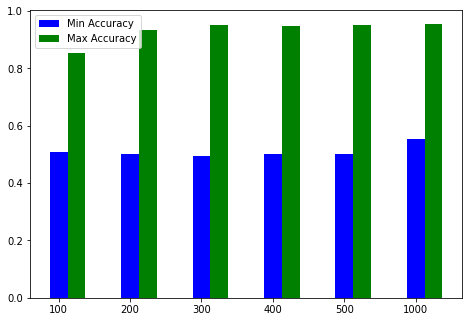

In [211]:
data = [min_values, max_values]
Y = ["100", "200", "300",'400','500','1000']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
increment = 0.0

print(item)
ax.bar(Y, data[0], color = 'b', width = 0.25)
ax.bar(X + increment + 0.25, data[1], color = 'g', width = 0.25)
ax.legend(labels=['Min Accuracy', 'Max Accuracy'])


Line graph of max values from each run. 

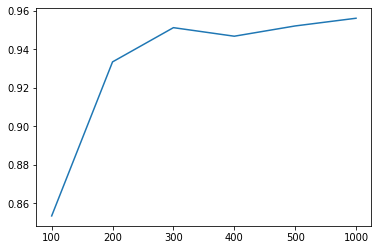

In [210]:
plt.plot(Y,max_values)